# <center> 분류 프로젝트 최종발표 - SS60</center>
## <center>Walmart Triptype Classification
## <center> 노승환, 백형렬, 이수정

# <center> 프로세스 </center>
# 0. 환경설정
# 1. 모델의 성능
# 2. 변수설명
# 3. 전처리 및 EDA
# 4. lightgbm을 사용한 분류
# 5. kaggle에 제출

# <center>0.환경설정</center>

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
import lightgbm
import warnings
import numpy as np
import pandas as pd
from IPython.display import Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.metrics import log_loss

%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# <center> 1. 모델의 성능 - lightgbm</center>

## 1-1. Accuracy

In [3]:
# 성능을 저장해놓고 보여주기 위한 코드입니다. 코드를 실행할 땐 전처리 과정을 모두 실행해줘야만 코드가 돌아갑니다.
# accuracy = 100 * (1 - (sum(int(y_pred[i]) != y_test[i]
#                            for i in range(len(y_test))) / float(len(y_test))))
# print("TripType Accuracy = %.2f%%" % accuracy)

## 1-2. Classification_report

In [4]:
# 성능을 저장해놓고 보여주기 위한 코드입니다. 코드를 실행할 땐 전처리 과정을 모두 실행해줘야만 코드가 돌아갑니다.
# print(classification_report(label_enc.inverse_transform(
#     y_test), label_enc.inverse_transform(y_pred)))

## 1-3. 캐글 submission : 170/1047(late submission)

# <center>2.데이터 및 변수 설명</center>

## walmart triptype classification : [walmart triptype classification](https://www.kaggle.com/c/walmart-recruiting-trip-type-classification)

## 약 3년전 종료된 kaggle competition으로, 월마트측에서 자체적으로 분류한 38가지의 고객 특성을 고객이 구매한 전산 데이터만을 사용해 고객 특성을 분류해보는것이 목적입니다.

## - 평가방식 : Multi-class log 

## <center>$-\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij}),$</center>

## - 분류할 타겟 : 고객의 특성 (38종류)

In [5]:
train.shape, test.shape

((647054, 7), (653646, 6))

In [6]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


# 2-1. `TripType`  [target]
- 이번 분석에서의 Target값

- 고객의 구매 활동을 나타내는 카테고리컬 식별값입니다. 
- 다른 변수들을 분석해 38가지 중에 하나로 분류해야 합니다. 
- TripType '999' 는 총 구매한 아이템의 수가 음수, 즉 최종 구매 활동이 반환 인 구매자를 의미합니다.

In [7]:
#print(train.TripType.unique())
print("{}가지 ID가 있습니다.".format(len(train.TripType.unique())))

38가지 ID가 있습니다.


## 고객특성에 해당하는 Triptype은 다음과 같이 분포해있습니다.

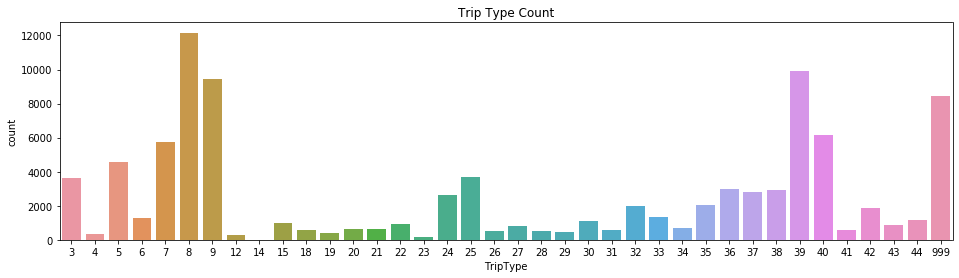

In [8]:
y = train[["TripType", 'VisitNumber']]
y.drop_duplicates(inplace=True)
y = y["TripType"]
plt.figure(figsize=(16, 4))
sns.countplot(y)
plt.title("Trip Type Count")
plt.show()

## TripType 999는 반품하러 온 사람들을 의미합니다.

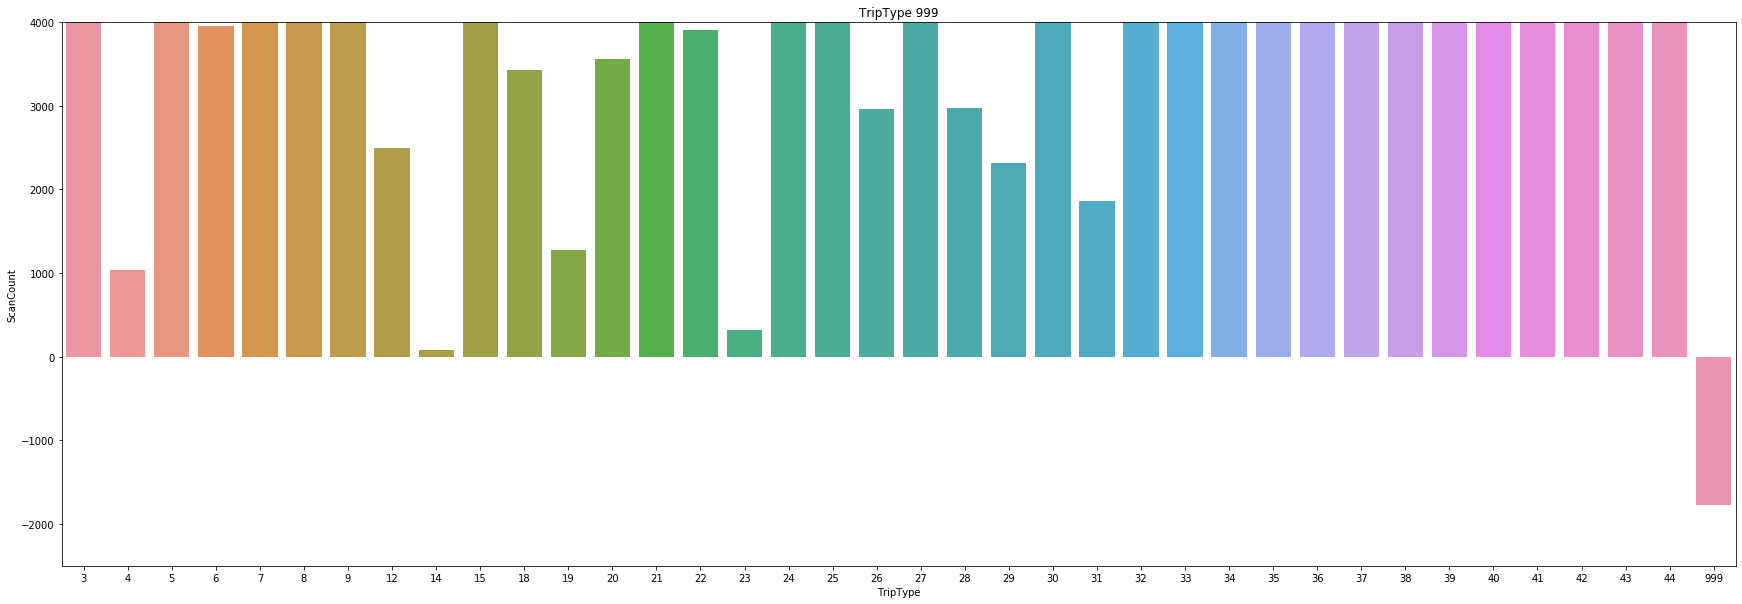

In [9]:
train_tt_sc = train.groupby('TripType', as_index=False)['ScanCount'].sum()

plt.figure(figsize=(30, 10))
sns.barplot(train_tt_sc['TripType'].astype('int'), train_tt_sc['ScanCount'])
plt.ylim(-2500, 4000)
plt.title("TripType 999")
plt.show()

# 2.2 `VisitNumber`
- 단일 고객의 단일 구매 활동을 나타내는 값
- 95674가지 값을 가집니다.

In [10]:
len(train.VisitNumber.unique())

95674

In [11]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


### 최종적으로 예측할 TripType은 VisitNumber별로 예측합니다. 같은 VisitNumber는 같은 TripType을 가짐을 알 수 있습니다.

# 2.3 `Weekday` 
- 거래가 일어난 요일을 나타냅니다.

In [12]:
print(train.Weekday.unique())

['Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday']


# 2.4 `ScanCount`
- 해당 상품을 한번에 몇 개 샀는지를 나타냅니다.
- 반품했을 경우 음수값으로 표시합니다.

In [13]:
#print(train.ScanCount.unique())
print(train.ScanCount.describe())

count    647054.000000
mean          1.108878
std           0.700776
min         -12.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          71.000000
Name: ScanCount, dtype: float64


# 2.5 `DepartmentDescription` 
- 상품 대분류
- 이 기준에 따르면 상품들은 68가지로 분류됩니다.

# 3-2.  `MENSWEAR` 와 `MENS WEAR`는 같은 값이므로 `MENSWEAR`로 합쳐줌

In [14]:
#MESWEAR -> MENS WEAR
train = train.replace('MENSWEAR', 'MENS WEAR')
test = test.replace('MENSWEAR', 'MENS WEAR')

In [15]:
print(len(train.DepartmentDescription.unique()))
print(train.DepartmentDescription.unique())

68
['FINANCIAL SERVICES' 'SHOES' 'PERSONAL CARE' 'PAINT AND ACCESSORIES'
 'DSD GROCERY' 'MEAT - FRESH & FROZEN' 'DAIRY' 'PETS AND SUPPLIES'
 'HOUSEHOLD CHEMICALS/SUPP' nan 'IMPULSE MERCHANDISE' 'PRODUCE'
 'CANDY, TOBACCO, COOKIES' 'GROCERY DRY GOODS' 'BOYS WEAR'
 'FABRICS AND CRAFTS' 'JEWELRY AND SUNGLASSES' 'MENS WEAR' 'ACCESSORIES'
 'HOME MANAGEMENT' 'FROZEN FOODS' 'SERVICE DELI'
 'INFANT CONSUMABLE HARDLINES' 'PRE PACKED DELI' 'COOK AND DINE'
 'PHARMACY OTC' 'LADIESWEAR' 'COMM BREAD' 'BAKERY' 'HOUSEHOLD PAPER GOODS'
 'CELEBRATION' 'HARDWARE' 'BEAUTY' 'AUTOMOTIVE' 'BOOKS AND MAGAZINES'
 'SEAFOOD' 'OFFICE SUPPLIES' 'LAWN AND GARDEN' 'SHEER HOSIERY' 'WIRELESS'
 'BEDDING' 'BATH AND SHOWER' 'HORTICULTURE AND ACCESS' 'HOME DECOR' 'TOYS'
 'INFANT APPAREL' 'LADIES SOCKS' 'PLUS AND MATERNITY' 'ELECTRONICS'
 'GIRLS WEAR, 4-6X  AND 7-14' 'BRAS & SHAPEWEAR' 'LIQUOR,WINE,BEER'
 'SLEEPWEAR/FOUNDATIONS' 'CAMERAS AND SUPPLIES' 'SPORTING GOODS'
 'PLAYERS AND ELECTRONICS' 'PHARMACY RX' 'OPTICAL - FRA

# 2.6 `FinelineNumber` 
- 월마트가 자체적으로 사용하는 세분화된 상품 분류 코드
- 이 기준에 따르면 상품들은 5196가지로 분류됩니다.

In [16]:
print(len(train.FinelineNumber.unique()))
#print(train.FinelineNumber.unique())

5196


# 2.7 `Upc`
- Universal Product Code. 구매한 제품의 고유값
- 97715개 상품이 팔렸습니다.

## -  UPC란 우리가 흔히 알고있는 바코드를 의미합니다. full UPC는 12자리입니다.


## - 데이터셋에서 UPC의 길이가 다 다름을 알 수 있습니다. UPC의 앞 6자리는 제품을 생산한 회사를 의미하므로, 길이가 6 미만인 것들은 월마트에서 자체생산한 상품임을 알 수 있습니다.(치킨 등 음식류) 

In [17]:
len(train.Upc.unique())

97715

# <center>3.전처리 및 EDA</center>

# 3-1. `TripType` 별 많이 나오는 상품 분류
- 타입별로 어떤 물건을 사러 온 손님인지 뚜렷하게 구분이 되는 경우가 많습니다.

In [18]:
description = {
    3: "타입3은 Financial Services가 주를 이룹니다.",
    4: "타입4는 Pharmacy OTC가 가장 많이 나옵니다.",
    5: "타입5도 Pharmacy OTC가 가장 많이 나오는데 좀 더 살펴볼 필요가 있습니다.",
    6: "타입6은 음주자 타입인듯 합니다. 주류가 가장 많고, 안주꺼리인 캔디, 쿠키, 담배 등도 있습니다.",
    7: "타입7은 '배고픈 사람' 타입인듯 합니다. 조리 식품, 식료품, 냉동식품 등이 있습니다.",
    8: "타입8은 일반 가정에서 필요한 물건을 ('장보러') 사러 온 타입인듯 합니다. 식료품이 가장 많이 나타나고, Personal Care가 뒤를 잇습니다.",
    9: "타입9은 남성 고객군인듯 합니다. 남성복과 자동차용품, 사무용품 등을 많이 구매했습니다.",
    12: "타입12는 뚜렷한 특성을 찾기 어렵습니다.",
    14: "타입14는 소소한 취미 타입인듯 합니다. 직물, 수공예품, 애완용품, 게임 등을 구매했습니다.",
    15: "타입15는 파티 타입인듯 합니다. Celebration이 주를 이룹니다.",
    18: "타입18은 장난감 타입입니다. Toys가 가장 많이 보입니다",
    19: "타입19는 전자기기를 사러 온 고객인듯 합니다. Electronics가 가장 많고 나머지는 미미합니다.",
    20: "타입20은 자동차용품을 사러 온 고객인듯 합니다. Automotive가 가장 많고 나머지는 미미합니다.",
    21: "타입21은 잘 알아차리기 어렵습니다. Fabrics and Crafts와 사무용품이 비슷하게 많습니다.",
    22: "타입22는 게이머 고객인듯 합니다. Electronics가 가장 많고 Media and Gaming도 많습니다.",
    23: "타입23은 Players and Electronics와 Media and Gaming 순으로 많습니다. 타입 22와 비교해 볼 필요가 있습니다.",
    24: "타입24는 집순이형 타입입니다. 요리, 집안 관리, 세면용품, 홈 데코 등이 있습니다.",
    25: "타입25는 가족들 옷을 사러온 타입입니다. 남성복, 여성복, 아이들 옷 등이 주를 이룹니다.",
    26: "타입26은 철물점 타입입니다. Hardware가 가장 많고 페인트와 장식품 등이 있습니다.",
    27: "타입27은 정원관리형 타입입니다. Lawn and Garden과 Horticulture and Access가 많습니다.",
    28: "타입28은 스포츠 타입입니다. 스포츠용품 구매가 가장 많습니다.",
    29: "타입29는 장난감 타입입니다. Toys, Sporting Goods 순으로 많습니다.",
    30: "타입30은 신발 사러 온 사람들입니다. Shoes가 가장 많습니다.",
    31: "타입31은 통신 관련 소비자군입니다. Wireless가 대부분입니다.",
    32: "타입32는 아기용품을 구매하는 타입입니다.",
    33: "타입33은 집관리형입니다. Household Chemical Supply가 많습니다.",
    34: "타입34는 애완용품형입니다. Pets and supplies가 많습니다.",
    35: "타입35는 DSD 타입입니다. DSD(Direct Store delivery)란 점포 직접 납품의 약자로, 공급업체가 상품을 유통업체의 물류센터를 경유하지 않고 점포로 직접 납품하는 형태를 말합니다.",
    36: "타입36은 피부 미용 타입입니다. Personal Care, Beauty가 많습니다.",
    37: "타입37은 채소 등 농산물 타입입니다. Produce가 가장 많습니다.",
    38: "타입38은 유제품 타입입니다. Dairy가 가장 많습니다.",
    39: "타입39는 DSD Grocery, Grocery Dry Goods가 가장 많습니다.",
    40: "타입40은 곡류 타입입니다. Grocery Dry Goods 위주입니다.",
    41: "타입41은 뚜렷한 특징을 찾기 어렵습니다.",
    42: "타입42는 충동구매 타입인듯 합니다. Impulse Merchandise 구매가 가장 많습니다.",
    43: "타입43도 뚜렷한 특징을 찾기 어렵습니다. Personal Care, DSD Grocery 등이 낮은 빈도로 있습니다",
    44: "타입44는 Personal Care가 가장 많습니다.",
    999: "타입999는 Financial Service가 주류를 이룹니다. 위에서 봤듯 반품을 위한 방문이며, 반품의 경우 Financial Service로 분류되는듯 합니다. 반품을 하면서도 이것저것 구매한다고 추측해볼 수 있습니다."
}

In [19]:
def show_plot(num):
    data = train[train['TripType'] == num][["TripType", "DepartmentDescription"]]
    plt.figure(figsize=(15, 2))
    data.DepartmentDescription.value_counts().head(10).plot(kind="bar", rot=15, title="TripType {}".format(num), color="orange")
    plt.show()
    print(description[num])
    print(" ")

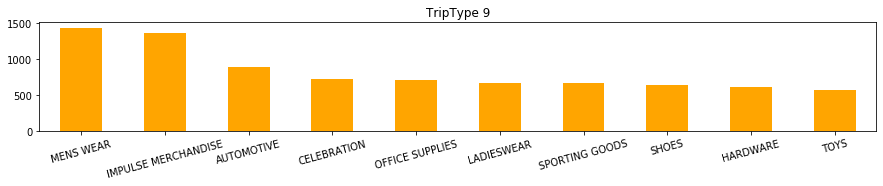

타입9은 남성 고객군인듯 합니다. 남성복과 자동차용품, 사무용품 등을 많이 구매했습니다.
 


In [20]:
show_plot(9)

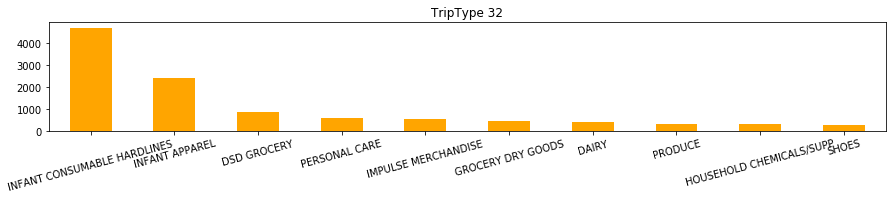

타입32는 아기용품을 구매하는 타입입니다.
 


In [21]:
show_plot(32)

# 3-2.  `MENSWEAR` 와 `MENS WEAR`는 같은 값이므로 `MENSWEAR`로 합쳐줌

In [22]:
# len(train["DepartmentDescription"].unique().tolist())
# train = train.replace('MENSWEAR', 'MENS WEAR')
# test = test.replace('MENSWEAR', 'MENS WEAR')

# 3-3. `TripType` 별 `DepartmentDescription` 분포

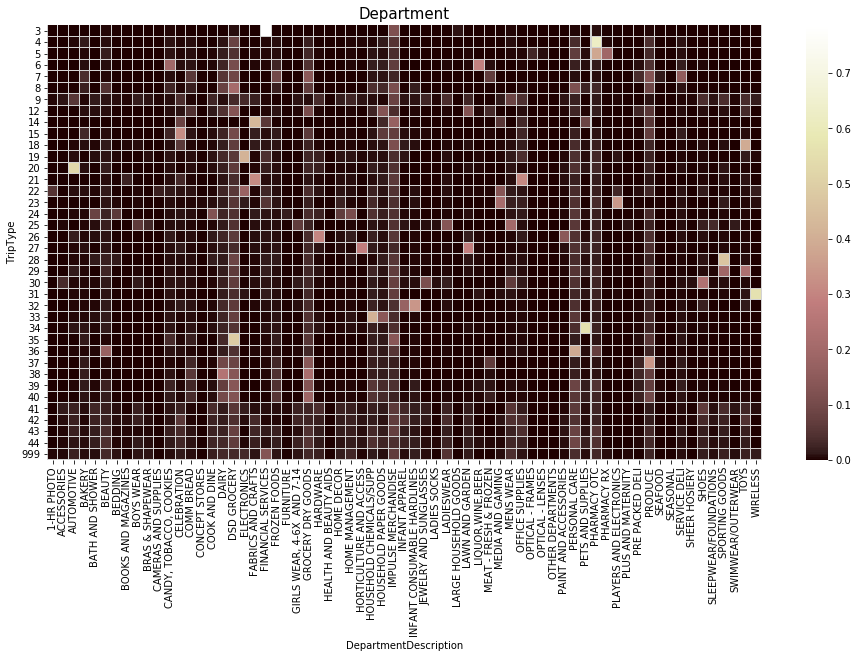

In [23]:
triptype_desc = pd.crosstab(train["TripType"],
                            train["DepartmentDescription"],
                            values=train["ScanCount"],
                            aggfunc="count",
                            normalize="index")

plt.figure(figsize=(16, 8))
sns.heatmap(triptype_desc, linecolor="lightgrey",
            linewidths=0.02, cmap="pink", alpha=1)
plt.title("Department", fontsize=15)
plt.show()

## 한 고객 특성에서 하나의 물품 종류만을 구매하는것이 아니라는걸 확인할 수 있습니다.

# 3-4. `DepartmentDescription`, `FinelineNumber`의 관계

###  `FinelineNumber`이 nan일 경우, `Upc`가 함께 nan이며 `DepartmentDescription`는 nan 혹은 `PHARMACY RX`입니다.

In [24]:
train.isna().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

# 3-4. pos_sum, neg_sum, return 컬럼 생성

In [25]:
train.loc[train["ScanCount"] < 0, "Return"] = 1
train.loc[train["Return"] != 1, "Return"] = 0

test.loc[test["ScanCount"] < 0, "Return"] = 1
test.loc[test["Return"] != 1, "Return"] = 0

In [26]:
train["Pos_Sum"] = train["ScanCount"]
test["Pos_Sum"] = test["ScanCount"]

train.loc[train["Pos_Sum"] < 0, "Pos_Sum"] = 0
test.loc[test["Pos_Sum"] < 0, "Pos_Sum"] = 0

In [27]:
train["Neg_Sum"] = train["ScanCount"]
test["Neg_Sum"] = test["ScanCount"]

train.loc[train["Neg_Sum"] > 0, "Neg_Sum"] = 0
test.loc[test["Neg_Sum"] > 0, "Neg_Sum"] = 0

In [28]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,Pos_Sum,Neg_Sum
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,1.0,0,-1
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,0.0,1,0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,0.0,1,0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,0.0,2,0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,0.0,2,0


# 3-5. UPC와 관련컬럼 생성

In [29]:
def float_to_str(obj):
    """
    Convert Upc code from float to string
    Use this function by applying lambda
    :param obj: "Upc" column of DataFrame
    :return: string converted Upc removing dot.
    """
    while obj != "nan":
        obj = str(obj).split(".")[0]
        return obj

In [30]:
def company(x):
    """
    Return company code from given Upc code.
    :param x: "Upc" column of DataFrame
    :return: company code
    """
    try:
        p = x[:6]
        if p == "000000":
            return x[-5]
        return p
    except:
        return -9999

In [31]:
train["Upc"] = train.Upc.apply(float_to_str)
test["Upc"] = test.Upc.apply(float_to_str)

train["company"] = train.Upc.apply(company)
test["company"] = test.Upc.apply(company)

## Upc에 포함되어있는 회사정보를 추출

In [32]:
train.tail()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,Pos_Sum,Neg_Sum,company
647049,39,191346,Sunday,32390001778,1,PHARMACY OTC,1118.0,0.0,1,0,323900
647050,39,191346,Sunday,7874205336,1,FROZEN FOODS,1752.0,0.0,1,0,787420
647051,39,191346,Sunday,4072,1,PRODUCE,4170.0,0.0,1,0,4072
647052,8,191347,Sunday,4190007664,1,DAIRY,1512.0,0.0,1,0,419000
647053,8,191347,Sunday,3800059655,1,GROCERY DRY GOODS,3600.0,0.0,1,0,380005


In [33]:

train_com = train.loc[:, ['VisitNumber', 'company']].drop_duplicates()
train_com['val'] = True
train_company = train_com.pivot('VisitNumber', 'company', 'val').fillna(False)
train_company.tail()

company,100866,101644,101645,101810,101811,101990,101991,102735,102791,102797,...,9899,993389,995000,995550,995551,996062,998000,999239,999880,nan
VisitNumber,,,,,,,,,,,,,,,,,,,,,
191343,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
191344,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
191345,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
191346,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
191347,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [34]:
test_com = test.loc[:, ['VisitNumber', 'company']].drop_duplicates()
test_com['val'] = True
test_company = test_com.pivot('VisitNumber', 'company', 'val').fillna(False)

In [35]:
test_company

company,100866,100868,101644,101645,101810,101811,101990,101991,102791,102797,...,9898,9899,993389,995000,995550,995551,998000,999239,999880,nan
VisitNumber,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191338,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
191339,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
191340,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Upc길이를 나타내는 데이터 프레임

In [41]:
train_upc_fine = train[["VisitNumber", "Upc"]]
test_upc_fine = test[["VisitNumber", "Upc"]]

In [43]:
train_upc_fine["Upc"] = train_upc_fine.Upc.apply(float_to_str) # return 을 저자리에 쓰면 안될것 같긴함
test_upc_fine["Upc"] = test_upc_fine.Upc.apply(float_to_str)

In [44]:
train_upc_fine["Upc"] = train_upc_fine.Upc.apply(float_to_str)
test_upc_fine["Upc"] = test_upc_fine.Upc.apply(float_to_str)

train_upc_fine["len_of_UPC"] = train_upc_fine["Upc"].apply(lambda x: len(x))
test_upc_fine["len_of_UPC"] = test_upc_fine["Upc"].apply(lambda x: len(x))

In [45]:
train_UPC = pd.get_dummies(train_upc_fine["len_of_UPC"])
train_UPC = pd.concat([train[["VisitNumber"]], train_UPC], axis=1)
train_UPC = train_UPC.groupby("VisitNumber", as_index=False).sum()

In [46]:
test_UPC = pd.get_dummies(test_upc_fine["len_of_UPC"])
test_UPC = pd.concat([test[["VisitNumber"]], test_UPC], axis=1)
test_UPC = test_UPC.groupby("VisitNumber", as_index=False).sum()

In [47]:
train_upc_fine.tail()

,VisitNumber,Upc,len_of_UPC
647049,191346,32390001778,11
647050,191346,7874205336,10
647051,191346,4072,4
647052,191347,4190007664,10
647053,191347,3800059655,10


In [48]:
train_UPC.tail()

,VisitNumber,3,4,5,7,8,9,10,11,12
95669,191343,0,0,0,0,0,0,2,5,0
95670,191344,0,0,0,0,0,0,3,2,0
95671,191345,0,0,0,0,0,0,11,2,0
95672,191346,0,1,0,0,0,0,15,1,0
95673,191347,0,0,0,0,0,0,2,0,0


# 3-6. Fineline 칼럼 생성

In [49]:
train_FL = pd.get_dummies(train["FinelineNumber"])
test_FL = pd.get_dummies(test["FinelineNumber"])

In [50]:
train_FL = pd.concat([train[["VisitNumber"]], train_FL], axis=1)
test_FL = pd.concat([test[["VisitNumber"]], test_FL], axis=1)

In [51]:
train_FL = train_FL.groupby("VisitNumber", as_index=False).sum()
test_FL = test_FL.groupby("VisitNumber", as_index=False).sum()

In [52]:
train_FL.tail()

,VisitNumber,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,9964.0,9966.0,9967.0,9970.0,9971.0,9974.0,9975.0,9991.0,9997.0,9998.0
95669,191343,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191344,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95671,191345,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,191347,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3-7. Department Description과 관련 칼럼 생성

In [53]:
train_dd = pd.get_dummies(train["DepartmentDescription"])
test_dd = pd.get_dummies(test["DepartmentDescription"])

train_dd = pd.concat([train[["VisitNumber"]], train_dd], axis=1)
test_dd = pd.concat([test[["VisitNumber"]], test_dd], axis=1)

train_dd = train_dd.groupby("VisitNumber", as_index=False).sum()
test_dd = test_dd.groupby("VisitNumber", as_index=False).sum()
train_dd.tail()

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
95669,191343,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191344,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
95671,191345,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,191347,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
category_dict = {
    'wear' : ['WEAR', 'SOCKS', 'SHOES', 'MATERNITY'],
    'food' : ['FOOD', 'MEAT', 'DAIRY','GROCERY', 'PRODUCE', 'BREAD', 'BAKERY', 'WINE', 'DELI', 'COOKIE', 'COOK'],
    'acc' : ['SUNGLASS','OPTICAL'],
    'electronic' : ['ELECTRONICS', 'CAMERAS', 'MEDIA', 'WIRELESS', 'HARDWARE'],
    'cosmetic' : ['PERSONAL', 'BEAUTY', 'PHARMACY', 'BATH'],
    'house' : ['PAPER', 'HOME', 'BEDDING', 'HOUSE', 'CELE', 'OFFICE'],
    'garden' : ['GARDEN', 'HORTI'],
    'infant' : ['INFANT']
       
}

In [61]:
traincolumn = list(train_dd.columns)

In [62]:
str_traincolumn = [x for x in traincolumn if type(x) == str]

In [63]:
def str_func(categories, words):
    ls = []
    for word in words:
        for category in categories:
            if word in category:
                ls.append(category)
    return ls

In [64]:

WEARls = str_func(str_traincolumn, category_dict['wear'])
FOODls = str_func(str_traincolumn, category_dict['food'])
ACCls = str_func(str_traincolumn, category_dict['acc'])
ELECls = str_func(str_traincolumn, category_dict['electronic'])
COSls = str_func(str_traincolumn, category_dict['cosmetic'])
HOUSEls = str_func(str_traincolumn, category_dict['house'])
GARDENls = str_func(str_traincolumn, category_dict['garden'])
INFANls = str_func(str_traincolumn, category_dict['infant'])


In [65]:
traindf = train.copy()
testdf = test.copy()
traindf.loc[traindf['DepartmentDescription'].isin(INFANls), "DD_big"] = "INFAN"
traindf.loc[traindf['DepartmentDescription'].isin(
    GARDENls), "DD_big"] = "GARDEN"
traindf.loc[traindf['DepartmentDescription'].isin(HOUSEls), "DD_big"] = "HOUSE"
traindf.loc[traindf['DepartmentDescription'].isin(COSls), "DD_big"] = "COS"
traindf.loc[traindf['DepartmentDescription'].isin(ELECls), "DD_big"] = "ELEC"
traindf.loc[traindf['DepartmentDescription'].isin(ACCls), "DD_big"] = "ACC"
traindf.loc[traindf['DepartmentDescription'].isin(FOODls), "DD_big"] = "FOOD"
traindf.loc[traindf['DepartmentDescription'].isin(WEARls), "DD_big"] = "WEAR"

testdf.loc[testdf['DepartmentDescription'].isin(INFANls), "DD_big"] = "INFAN"
testdf.loc[testdf['DepartmentDescription'].isin(GARDENls), "DD_big"] = "GARDEN"
testdf.loc[testdf['DepartmentDescription'].isin(HOUSEls), "DD_big"] = "HOUSE"
testdf.loc[testdf['DepartmentDescription'].isin(COSls), "DD_big"] = "COS"
testdf.loc[testdf['DepartmentDescription'].isin(ELECls), "DD_big"] = "ELEC"
testdf.loc[testdf['DepartmentDescription'].isin(ACCls), "DD_big"] = "ACC"
testdf.loc[testdf['DepartmentDescription'].isin(FOODls), "DD_big"] = "FOOD"
testdf.loc[testdf['DepartmentDescription'].isin(WEARls), "DD_big"] = "WEAR"

In [66]:
train_dd_big = pd.get_dummies(traindf["DD_big"])
test_dd_big = pd.get_dummies(testdf["DD_big"])

train_dd_big = pd.concat([traindf[["VisitNumber"]], train_dd_big], axis=1)
test_dd_big = pd.concat([testdf[["VisitNumber"]], test_dd_big], axis=1)

train_dd_big = train_dd_big.groupby("VisitNumber", as_index=False).sum()
test_dd_big = test_dd_big.groupby("VisitNumber", as_index=False).sum()
test_dd_big.tail()

,VisitNumber,ACC,COS,ELEC,FOOD,GARDEN,HOUSE,INFAN,WEAR
95669,191338,0,0,0,3,0,4,0,0
95670,191339,0,0,0,0,0,0,0,0
95671,191340,0,0,0,0,0,0,0,0
95672,191341,0,0,0,0,0,4,6,0
95673,191348,0,2,0,0,0,0,0,5


# 3-8. 요일과 관련된 칼럼 생성

In [67]:
weekday = {"Monday": 0,
           "Tuesday": 1,
           "Wednesday": 2,
           "Thursday": 3,
           "Friday": 4,
           "Saturday": 5,
           "Sunday": 6}
train_weekday_df = train[["Weekday", "VisitNumber", "TripType"]]
train_weekday_df["Weekday"] = train_weekday_df["Weekday"].apply(lambda x: weekday[x])

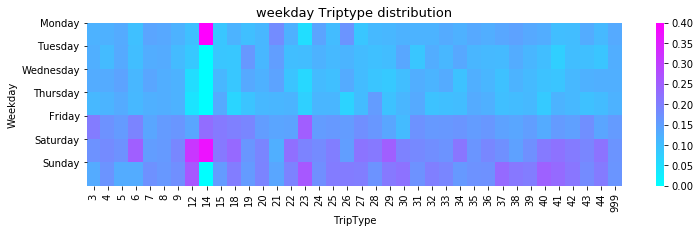

In [68]:
plt.figure(figsize=(12, 3))
sns.heatmap(data=pd.crosstab(train_weekday_df["Weekday"],
                             train_weekday_df["TripType"],
                             values=train_weekday_df["VisitNumber"],
                             aggfunc='count',
                             normalize="columns"), cmap="cool")
plt.yticks(range(0, 7), list(weekday.keys()), rotation="horizontal")
plt.title("weekday Triptype distribution", fontsize=13)
plt.show()

In [69]:
train_weekday = pd.get_dummies(train["Weekday"])
test_weekday = pd.get_dummies(test["Weekday"])

train_weekday = pd.concat([train[["VisitNumber"]], train_weekday], axis=1)
test_weekday = pd.concat([test[["VisitNumber"]], test_weekday], axis=1)

train_weekday = train_weekday.groupby("VisitNumber", as_index=False).sum()
test_weekday = test_weekday.groupby("VisitNumber", as_index=False).sum()
train_weekday.tail()

,VisitNumber,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
95669,191343,0,0,0,7,0,0,0
95670,191344,0,0,0,5,0,0,0
95671,191345,0,0,0,13,0,0,0
95672,191346,0,0,0,17,0,0,0
95673,191347,0,0,0,2,0,0,0


# 3-7. 데이터 프레임 병합

In [70]:
train_by_sum = train[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]
test_by_sum = test[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]

train_by_sum = train_by_sum.groupby("VisitNumber", as_index=False).sum()
test_by_sum = test_by_sum.groupby("VisitNumber", as_index=False).sum()

train = train_by_sum.merge(train_dd, on=["VisitNumber"])
train = train.merge(train_UPC, on=["VisitNumber"])
train = train.merge(train_dd_big, on=["VisitNumber"])
train = train.merge(train_FL, on=["VisitNumber"])
train = train.merge(train_weekday, on=["VisitNumber"])

test = test_by_sum.merge(test_dd, on=["VisitNumber"])
test = test.merge(test_UPC, on=["VisitNumber"])
test = test.merge(test_dd_big, on=["VisitNumber"])
test = test.merge(test_FL, on=["VisitNumber"])
test = test.merge(test_weekday, on=["VisitNumber"])

In [71]:
train = pd.merge(train, train_company, on='VisitNumber')
test = pd.merge(test, test_company, on='VisitNumber')

In [72]:
y = traindf[["TripType", 'VisitNumber']]
y.drop_duplicates(inplace=True)
y = y["TripType"]

In [73]:
train.tail()

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,9899,993389,995000,995550,995551,996062,998000,999239,999880,nan
95669,191343,9,9,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
95670,191344,5,5,0,0,0,0,0,0,4,...,False,False,False,False,False,False,False,False,False,False
95671,191345,17,17,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
95672,191346,17,17,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
95673,191347,2,2,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


# 3-8. data shape

In [74]:
not_in_train = [i for i in test.columns if i not in train.columns]
not_in_test = [i for i in train.columns if i not in test.columns]

# train과 test에서 서로 겹치지 않는 컬럼들은 제거하고 학습

In [75]:
total_train = train.drop(columns=not_in_test)

In [76]:
total_test = test.drop(columns=not_in_train)

In [77]:
total_train = total_train.drop(columns="VisitNumber")
total_test = total_test.drop(columns="VisitNumber")

# <center>4. lightgbm을 사용한 분류</center>

In [192]:
label_enc = LabelEncoder()
y_labeled = label_enc.fit_transform(y)

In [212]:
total_train = total_train.drop(columns='nan')


In [218]:
total_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in total_train.columns]

In [219]:
X_train, X_test, y_train, y_test = train_test_split(
    total_train, y_labeled, random_state=0)

In [220]:
dtrain = lightgbm.Dataset(X_train, label=y_train)

In [221]:
dtest = lightgbm.Dataset(X_test, label=y_test)

In [222]:
num_boost_round = 2000
learning_rate = 0.02

params = {'objective': 'multiclass',
          'boosting_type': 'gbdt',
          'max_depth': 10,
          'nthread': 4,
          'metric': 'multi_logloss',
          'num_class': 38,
          'learning_rate': learning_rate,
          }

#여기까지 코드 정리 완료함

In [223]:
lightgbm_model = lightgbm.train(params=params,
                                train_set=dtrain,
                                valid_sets=[dtrain, dtest],
                                num_boost_round=num_boost_round,
                                early_stopping_rounds=10)

[1]	training's multi_logloss: 2.9155	valid_1's multi_logloss: 2.92207
Training until validation scores don't improve for 10 rounds
[2]	training's multi_logloss: 2.80838	valid_1's multi_logloss: 2.82017
[3]	training's multi_logloss: 2.71952	valid_1's multi_logloss: 2.73486
[4]	training's multi_logloss: 2.64172	valid_1's multi_logloss: 2.66032
[5]	training's multi_logloss: 2.57211	valid_1's multi_logloss: 2.59358
[6]	training's multi_logloss: 2.50883	valid_1's multi_logloss: 2.53281
[7]	training's multi_logloss: 2.4508	valid_1's multi_logloss: 2.47715
[8]	training's multi_logloss: 2.39703	valid_1's multi_logloss: 2.42541
[9]	training's multi_logloss: 2.34696	valid_1's multi_logloss: 2.37741
[10]	training's multi_logloss: 2.29977	valid_1's multi_logloss: 2.33229
[11]	training's multi_logloss: 2.25539	valid_1's multi_logloss: 2.28962
[12]	training's multi_logloss: 2.21361	valid_1's multi_logloss: 2.24953
[13]	training's multi_logloss: 2.174	valid_1's multi_logloss: 2.21152
[14]	training's 

[115]	training's multi_logloss: 0.916275	valid_1's multi_logloss: 1.0289
[116]	training's multi_logloss: 0.912183	valid_1's multi_logloss: 1.02529
[117]	training's multi_logloss: 0.908113	valid_1's multi_logloss: 1.02171
[118]	training's multi_logloss: 0.904128	valid_1's multi_logloss: 1.01816
[119]	training's multi_logloss: 0.90014	valid_1's multi_logloss: 1.01469
[120]	training's multi_logloss: 0.896235	valid_1's multi_logloss: 1.01126
[121]	training's multi_logloss: 0.892394	valid_1's multi_logloss: 1.00793
[122]	training's multi_logloss: 0.888569	valid_1's multi_logloss: 1.00456
[123]	training's multi_logloss: 0.88487	valid_1's multi_logloss: 1.00136
[124]	training's multi_logloss: 0.881148	valid_1's multi_logloss: 0.998103
[125]	training's multi_logloss: 0.87754	valid_1's multi_logloss: 0.994948
[126]	training's multi_logloss: 0.873919	valid_1's multi_logloss: 0.99181
[127]	training's multi_logloss: 0.870353	valid_1's multi_logloss: 0.988703
[128]	training's multi_logloss: 0.86682

[225]	training's multi_logloss: 0.65608	valid_1's multi_logloss: 0.81641
[226]	training's multi_logloss: 0.6547	valid_1's multi_logloss: 0.815423
[227]	training's multi_logloss: 0.653345	valid_1's multi_logloss: 0.814417
[228]	training's multi_logloss: 0.651964	valid_1's multi_logloss: 0.81343
[229]	training's multi_logloss: 0.650661	valid_1's multi_logloss: 0.812531
[230]	training's multi_logloss: 0.649333	valid_1's multi_logloss: 0.811584
[231]	training's multi_logloss: 0.648032	valid_1's multi_logloss: 0.810655
[232]	training's multi_logloss: 0.646728	valid_1's multi_logloss: 0.809736
[233]	training's multi_logloss: 0.645424	valid_1's multi_logloss: 0.808814
[234]	training's multi_logloss: 0.644164	valid_1's multi_logloss: 0.807953
[235]	training's multi_logloss: 0.642904	valid_1's multi_logloss: 0.807056
[236]	training's multi_logloss: 0.641646	valid_1's multi_logloss: 0.806182
[237]	training's multi_logloss: 0.640413	valid_1's multi_logloss: 0.805345
[238]	training's multi_logloss

[335]	training's multi_logloss: 0.548203	valid_1's multi_logloss: 0.749073
[336]	training's multi_logloss: 0.547447	valid_1's multi_logloss: 0.748665
[337]	training's multi_logloss: 0.546739	valid_1's multi_logloss: 0.748319
[338]	training's multi_logloss: 0.546023	valid_1's multi_logloss: 0.747931
[339]	training's multi_logloss: 0.545298	valid_1's multi_logloss: 0.747554
[340]	training's multi_logloss: 0.544595	valid_1's multi_logloss: 0.747204
[341]	training's multi_logloss: 0.543877	valid_1's multi_logloss: 0.746831
[342]	training's multi_logloss: 0.543174	valid_1's multi_logloss: 0.746472
[343]	training's multi_logloss: 0.542464	valid_1's multi_logloss: 0.74609
[344]	training's multi_logloss: 0.541761	valid_1's multi_logloss: 0.745729
[345]	training's multi_logloss: 0.541073	valid_1's multi_logloss: 0.745379
[346]	training's multi_logloss: 0.540396	valid_1's multi_logloss: 0.745055
[347]	training's multi_logloss: 0.539692	valid_1's multi_logloss: 0.744711
[348]	training's multi_log

[445]	training's multi_logloss: 0.482576	valid_1's multi_logloss: 0.718169


KeyboardInterrupt: 

In [218]:
label_enc_1 = LabelEncoder()
y_labeled_1 = label_enc_1.fit_transform(y)

Xtrain, Xtest, ytrain, ytest = train_test_split(
    total_train, y_labeled, random_state=0)

lgb_train = lightgbm.Dataset(Xtrain, ytrain)
lgb_eval = lightgbm.Dataset(Xtest, ytest)

pred_test = pd.DataFrame(total_test.index)
parameters = pd.DataFrame({
    "1Learning_rate": [0],
    "2max_depth": [0],
    "3Log_loss": [0]})

learning_rate = [0.03, 0.025, 0.02]
max_depth = [10, 20, 30, 50]

In [219]:
import time
l_loss = 0
for lr in learning_rate:
    for depth in max_depth:
        params = {"learning_rate": lr,
                  "max_depth": depth,
                  'objective': 'multiclass',
                  'boosting_type': 'gbdt',
                  'metric': 'multi_logloss',
                  'nthread': 4,
                  'num_class': 38}

        s = time.time()

        clf = lightgbm.train(params=params,
                             train_set=lgb_train,
                             valid_sets=[lgb_train, lgb_eval],
                             num_boost_round=2000,
                             early_stopping_rounds=10)

        print(time.time() - s)
        prob = clf.predict(Xtest)

        r = pd.DataFrame({
            "1Learning_rate": [lr],
            "2max_depth": [depth],
            "3Log_loss": log_loss(ytest, prob)
        })
        parameters = r.append(parameters)

        tmp = log_loss(ytest, prob)


[1]	training's multi_logloss: 2.84104	valid_1's multi_logloss: 2.85045
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 2.70472	valid_1's multi_logloss: 2.72228
[3]	training's multi_logloss: 2.60357	valid_1's multi_logloss: 2.62482
[4]	training's multi_logloss: 2.50305	valid_1's multi_logloss: 2.53013
[5]	training's multi_logloss: 2.41887	valid_1's multi_logloss: 2.44922
[6]	training's multi_logloss: 2.34323	valid_1's multi_logloss: 2.374
[7]	training's multi_logloss: 2.27456	valid_1's multi_logloss: 2.30994
[8]	training's multi_logloss: 2.21147	valid_1's multi_logloss: 2.25026
[9]	training's multi_logloss: 2.15864	valid_1's multi_logloss: 2.20952
[10]	training's multi_logloss: 2.09977	valid_1's multi_logloss: 2.14298
[11]	training's multi_logloss: 2.04902	valid_1's multi_logloss: 2.09382
[12]	training's multi_logloss: 2.00311	valid_1's multi_logloss: 2.04898
[13]	training's multi_logloss: 1.95299	valid_1's multi_logloss: 2.00433
[14]	training

[114]	training's multi_logloss: 0.76016	valid_1's multi_logloss: 0.928576
[115]	training's multi_logloss: 0.756978	valid_1's multi_logloss: 0.926013
[116]	training's multi_logloss: 0.753753	valid_1's multi_logloss: 0.923392
[117]	training's multi_logloss: 0.750951	valid_1's multi_logloss: 0.920984
[118]	training's multi_logloss: 0.747733	valid_1's multi_logloss: 0.918529
[119]	training's multi_logloss: 0.744623	valid_1's multi_logloss: 0.915778
[120]	training's multi_logloss: 0.741659	valid_1's multi_logloss: 0.913462
[121]	training's multi_logloss: 0.738775	valid_1's multi_logloss: 0.911204
[122]	training's multi_logloss: 0.735908	valid_1's multi_logloss: 0.908996
[123]	training's multi_logloss: 0.733051	valid_1's multi_logloss: 0.906766
[124]	training's multi_logloss: 0.730211	valid_1's multi_logloss: 0.90455
[125]	training's multi_logloss: 0.727445	valid_1's multi_logloss: 0.902408
[126]	training's multi_logloss: 0.724739	valid_1's multi_logloss: 0.900322
[127]	training's multi_logl

[84]	training's multi_logloss: 0.859707	valid_1's multi_logloss: 1.02519
[85]	training's multi_logloss: 0.854222	valid_1's multi_logloss: 1.0204
[86]	training's multi_logloss: 0.848905	valid_1's multi_logloss: 1.01582
[87]	training's multi_logloss: 0.843671	valid_1's multi_logloss: 1.01124
[88]	training's multi_logloss: 0.838571	valid_1's multi_logloss: 1.00686
[89]	training's multi_logloss: 0.833541	valid_1's multi_logloss: 1.00251
[90]	training's multi_logloss: 0.82856	valid_1's multi_logloss: 0.998155
[91]	training's multi_logloss: 0.823737	valid_1's multi_logloss: 0.994021
[92]	training's multi_logloss: 0.819001	valid_1's multi_logloss: 0.99001
[93]	training's multi_logloss: 0.814361	valid_1's multi_logloss: 0.98601
[94]	training's multi_logloss: 0.809793	valid_1's multi_logloss: 0.982083
[95]	training's multi_logloss: 0.805303	valid_1's multi_logloss: 0.978251
[96]	training's multi_logloss: 0.800909	valid_1's multi_logloss: 0.974482
[97]	training's multi_logloss: 0.79658	valid_1's

[194]	training's multi_logloss: 0.560138	valid_1's multi_logloss: 0.799754
[195]	training's multi_logloss: 0.558667	valid_1's multi_logloss: 0.798848
[196]	training's multi_logloss: 0.557225	valid_1's multi_logloss: 0.79802
[197]	training's multi_logloss: 0.555774	valid_1's multi_logloss: 0.797137
[198]	training's multi_logloss: 0.55439	valid_1's multi_logloss: 0.796304
[199]	training's multi_logloss: 0.552927	valid_1's multi_logloss: 0.795449
[200]	training's multi_logloss: 0.551552	valid_1's multi_logloss: 0.794662
[201]	training's multi_logloss: 0.550165	valid_1's multi_logloss: 0.793908
[202]	training's multi_logloss: 0.548748	valid_1's multi_logloss: 0.793121
[203]	training's multi_logloss: 0.54767	valid_1's multi_logloss: 0.79234
[204]	training's multi_logloss: 0.546154	valid_1's multi_logloss: 0.791011
[205]	training's multi_logloss: 0.544787	valid_1's multi_logloss: 0.790212
[206]	training's multi_logloss: 0.543446	valid_1's multi_logloss: 0.789425
[207]	training's multi_loglos

[304]	training's multi_logloss: 0.443287	valid_1's multi_logloss: 0.738789
[305]	training's multi_logloss: 0.442504	valid_1's multi_logloss: 0.738497
[306]	training's multi_logloss: 0.441714	valid_1's multi_logloss: 0.738179
[307]	training's multi_logloss: 0.470946	valid_1's multi_logloss: 0.775702
[308]	training's multi_logloss: 0.487074	valid_1's multi_logloss: 0.791048
[309]	training's multi_logloss: 0.472943	valid_1's multi_logloss: 0.775941
[310]	training's multi_logloss: 0.492377	valid_1's multi_logloss: 0.803444
[311]	training's multi_logloss: 0.477761	valid_1's multi_logloss: 0.790629
[312]	training's multi_logloss: 0.499078	valid_1's multi_logloss: 0.809995
[313]	training's multi_logloss: 0.49954	valid_1's multi_logloss: 0.81905
[314]	training's multi_logloss: 0.526466	valid_1's multi_logloss: 0.845562
[315]	training's multi_logloss: 0.558912	valid_1's multi_logloss: 0.879372
[316]	training's multi_logloss: 0.583925	valid_1's multi_logloss: 0.903117
Early stopping, best iterat

[99]	training's multi_logloss: 0.797905	valid_1's multi_logloss: 0.960115
[100]	training's multi_logloss: 0.793766	valid_1's multi_logloss: 0.956654
[101]	training's multi_logloss: 0.789612	valid_1's multi_logloss: 0.953222
[102]	training's multi_logloss: 0.785581	valid_1's multi_logloss: 0.949873
[103]	training's multi_logloss: 0.781594	valid_1's multi_logloss: 0.946575
[104]	training's multi_logloss: 0.812497	valid_1's multi_logloss: 0.982086
[105]	training's multi_logloss: 0.777706	valid_1's multi_logloss: 0.943489
[106]	training's multi_logloss: 0.795639	valid_1's multi_logloss: 0.963875
[107]	training's multi_logloss: 0.788761	valid_1's multi_logloss: 0.966901
[108]	training's multi_logloss: 0.785974	valid_1's multi_logloss: 0.964196
[109]	training's multi_logloss: 0.784284	valid_1's multi_logloss: 0.959101
[110]	training's multi_logloss: 0.775409	valid_1's multi_logloss: 0.948277
[111]	training's multi_logloss: 0.77071	valid_1's multi_logloss: 0.943663
[112]	training's multi_logl

[209]	training's multi_logloss: 0.557354	valid_1's multi_logloss: 0.808413
[210]	training's multi_logloss: 0.555385	valid_1's multi_logloss: 0.80668
[211]	training's multi_logloss: 0.554045	valid_1's multi_logloss: 0.806008
[212]	training's multi_logloss: 0.552719	valid_1's multi_logloss: 0.805334
[213]	training's multi_logloss: 0.551421	valid_1's multi_logloss: 0.80466
[214]	training's multi_logloss: 0.550081	valid_1's multi_logloss: 0.803975
[215]	training's multi_logloss: 0.549674	valid_1's multi_logloss: 0.804655
[216]	training's multi_logloss: 0.548061	valid_1's multi_logloss: 0.80395
[217]	training's multi_logloss: 0.546772	valid_1's multi_logloss: 0.803288
[218]	training's multi_logloss: 0.545434	valid_1's multi_logloss: 0.802618
[219]	training's multi_logloss: 0.544066	valid_1's multi_logloss: 0.802026
[220]	training's multi_logloss: 0.542774	valid_1's multi_logloss: 0.801506
[221]	training's multi_logloss: 0.541446	valid_1's multi_logloss: 0.800811
[222]	training's multi_loglo

[38]	training's multi_logloss: 1.29053	valid_1's multi_logloss: 1.39952
[39]	training's multi_logloss: 1.27479	valid_1's multi_logloss: 1.38483
[40]	training's multi_logloss: 1.25954	valid_1's multi_logloss: 1.37061
[41]	training's multi_logloss: 1.24471	valid_1's multi_logloss: 1.35682
[42]	training's multi_logloss: 1.23026	valid_1's multi_logloss: 1.34337
[43]	training's multi_logloss: 1.21618	valid_1's multi_logloss: 1.33037
[44]	training's multi_logloss: 1.20252	valid_1's multi_logloss: 1.3177
[45]	training's multi_logloss: 1.18927	valid_1's multi_logloss: 1.30542
[46]	training's multi_logloss: 1.1764	valid_1's multi_logloss: 1.29339
[47]	training's multi_logloss: 1.16379	valid_1's multi_logloss: 1.2818
[48]	training's multi_logloss: 1.15149	valid_1's multi_logloss: 1.27054
[49]	training's multi_logloss: 1.14404	valid_1's multi_logloss: 1.26099
[50]	training's multi_logloss: 1.13712	valid_1's multi_logloss: 1.25698
[51]	training's multi_logloss: 1.13694	valid_1's multi_logloss: 1.2

[150]	training's multi_logloss: 0.660118	valid_1's multi_logloss: 0.862275
[151]	training's multi_logloss: 0.657967	valid_1's multi_logloss: 0.860651
[152]	training's multi_logloss: 0.655895	valid_1's multi_logloss: 0.859176
[153]	training's multi_logloss: 0.653996	valid_1's multi_logloss: 0.859195
[154]	training's multi_logloss: 0.652167	valid_1's multi_logloss: 0.858466
[155]	training's multi_logloss: 0.647709	valid_1's multi_logloss: 0.854735
[156]	training's multi_logloss: 0.661131	valid_1's multi_logloss: 0.855358
[157]	training's multi_logloss: 0.658639	valid_1's multi_logloss: 0.853826
[158]	training's multi_logloss: 0.647282	valid_1's multi_logloss: 0.850065
[159]	training's multi_logloss: 0.645017	valid_1's multi_logloss: 0.848633
[160]	training's multi_logloss: 0.642953	valid_1's multi_logloss: 0.847394
[161]	training's multi_logloss: 0.654919	valid_1's multi_logloss: 0.857328
[162]	training's multi_logloss: 0.647261	valid_1's multi_logloss: 0.848335
[163]	training's multi_lo

[260]	training's multi_logloss: 0.499703	valid_1's multi_logloss: 0.783903
[261]	training's multi_logloss: 0.498709	valid_1's multi_logloss: 0.783513
[262]	training's multi_logloss: 0.497511	valid_1's multi_logloss: 0.783054
[263]	training's multi_logloss: 0.496116	valid_1's multi_logloss: 0.782651
[264]	training's multi_logloss: 0.495157	valid_1's multi_logloss: 0.782468
[265]	training's multi_logloss: 0.494202	valid_1's multi_logloss: 0.782023
[266]	training's multi_logloss: 0.493261	valid_1's multi_logloss: 0.781683
[267]	training's multi_logloss: 0.492309	valid_1's multi_logloss: 0.781278
[268]	training's multi_logloss: 0.491368	valid_1's multi_logloss: 0.780872
[269]	training's multi_logloss: 0.490425	valid_1's multi_logloss: 0.780565
[270]	training's multi_logloss: 0.489462	valid_1's multi_logloss: 0.780167
[271]	training's multi_logloss: 0.488979	valid_1's multi_logloss: 0.780409
[272]	training's multi_logloss: 0.50493	valid_1's multi_logloss: 0.795531
[273]	training's multi_log

[91]	training's multi_logloss: 0.927171	valid_1's multi_logloss: 1.05805
[92]	training's multi_logloss: 0.921898	valid_1's multi_logloss: 1.05343
[93]	training's multi_logloss: 0.916845	valid_1's multi_logloss: 1.04861
[94]	training's multi_logloss: 0.911099	valid_1's multi_logloss: 1.04409
[95]	training's multi_logloss: 0.906132	valid_1's multi_logloss: 1.03977
[96]	training's multi_logloss: 0.900883	valid_1's multi_logloss: 1.03539
[97]	training's multi_logloss: 0.896685	valid_1's multi_logloss: 1.03169
[98]	training's multi_logloss: 0.891795	valid_1's multi_logloss: 1.02741
[99]	training's multi_logloss: 0.887095	valid_1's multi_logloss: 1.02328
[100]	training's multi_logloss: 0.882473	valid_1's multi_logloss: 1.0193
[101]	training's multi_logloss: 0.877952	valid_1's multi_logloss: 1.01542
[102]	training's multi_logloss: 0.873541	valid_1's multi_logloss: 1.01161
[103]	training's multi_logloss: 0.869142	valid_1's multi_logloss: 1.00784
[104]	training's multi_logloss: 0.864839	valid_1

[9]	training's multi_logloss: 2.24125	valid_1's multi_logloss: 2.27616
[10]	training's multi_logloss: 2.18398	valid_1's multi_logloss: 2.22338
[11]	training's multi_logloss: 2.13349	valid_1's multi_logloss: 2.17634
[12]	training's multi_logloss: 2.099	valid_1's multi_logloss: 2.14315
[13]	training's multi_logloss: 2.05583	valid_1's multi_logloss: 2.10215
[14]	training's multi_logloss: 2.00558	valid_1's multi_logloss: 2.05516
[15]	training's multi_logloss: 1.96718	valid_1's multi_logloss: 2.01848
[16]	training's multi_logloss: 1.9305	valid_1's multi_logloss: 1.98332
[17]	training's multi_logloss: 1.89543	valid_1's multi_logloss: 1.94982
[18]	training's multi_logloss: 1.86193	valid_1's multi_logloss: 1.91791
[19]	training's multi_logloss: 1.82987	valid_1's multi_logloss: 1.88723
[20]	training's multi_logloss: 1.79908	valid_1's multi_logloss: 1.85795
[21]	training's multi_logloss: 1.77991	valid_1's multi_logloss: 1.83673
[22]	training's multi_logloss: 1.75161	valid_1's multi_logloss: 1.80

[122]	training's multi_logloss: 0.776513	valid_1's multi_logloss: 0.946281
[123]	training's multi_logloss: 0.773177	valid_1's multi_logloss: 0.943444
[124]	training's multi_logloss: 0.7699	valid_1's multi_logloss: 0.940727
[125]	training's multi_logloss: 0.766633	valid_1's multi_logloss: 0.93797
[126]	training's multi_logloss: 0.763489	valid_1's multi_logloss: 0.935375
[127]	training's multi_logloss: 0.760334	valid_1's multi_logloss: 0.932775
[128]	training's multi_logloss: 0.757191	valid_1's multi_logloss: 0.930034
[129]	training's multi_logloss: 0.754034	valid_1's multi_logloss: 0.927374
[130]	training's multi_logloss: 0.751027	valid_1's multi_logloss: 0.92489
[131]	training's multi_logloss: 0.747974	valid_1's multi_logloss: 0.922422
[132]	training's multi_logloss: 0.745013	valid_1's multi_logloss: 0.919973
[133]	training's multi_logloss: 0.742126	valid_1's multi_logloss: 0.917648
[134]	training's multi_logloss: 0.739231	valid_1's multi_logloss: 0.915286
[135]	training's multi_loglos

[232]	training's multi_logloss: 0.559136	valid_1's multi_logloss: 0.787489
[233]	training's multi_logloss: 0.557921	valid_1's multi_logloss: 0.786786
[234]	training's multi_logloss: 0.556709	valid_1's multi_logloss: 0.786067
[235]	training's multi_logloss: 0.555537	valid_1's multi_logloss: 0.785409
[236]	training's multi_logloss: 0.554318	valid_1's multi_logloss: 0.784721
[237]	training's multi_logloss: 0.553112	valid_1's multi_logloss: 0.784029
[238]	training's multi_logloss: 0.551944	valid_1's multi_logloss: 0.78338
[239]	training's multi_logloss: 0.550787	valid_1's multi_logloss: 0.782732
[240]	training's multi_logloss: 0.549643	valid_1's multi_logloss: 0.782123
[241]	training's multi_logloss: 0.548473	valid_1's multi_logloss: 0.781417
[242]	training's multi_logloss: 0.547352	valid_1's multi_logloss: 0.780791
[243]	training's multi_logloss: 0.546232	valid_1's multi_logloss: 0.780162
[244]	training's multi_logloss: 0.545096	valid_1's multi_logloss: 0.779556
[245]	training's multi_log

[342]	training's multi_logloss: 0.458531	valid_1's multi_logloss: 0.740312
[343]	training's multi_logloss: 0.457827	valid_1's multi_logloss: 0.740027
[344]	training's multi_logloss: 0.457182	valid_1's multi_logloss: 0.739804
[345]	training's multi_logloss: 0.456475	valid_1's multi_logloss: 0.739531
[346]	training's multi_logloss: 0.455796	valid_1's multi_logloss: 0.739255
[347]	training's multi_logloss: 0.455074	valid_1's multi_logloss: 0.73893
[348]	training's multi_logloss: 0.454375	valid_1's multi_logloss: 0.73865
[349]	training's multi_logloss: 0.453677	valid_1's multi_logloss: 0.738327
[350]	training's multi_logloss: 0.452995	valid_1's multi_logloss: 0.738048
[351]	training's multi_logloss: 0.45231	valid_1's multi_logloss: 0.737784
[352]	training's multi_logloss: 0.451635	valid_1's multi_logloss: 0.737549
[353]	training's multi_logloss: 0.450953	valid_1's multi_logloss: 0.737269
[354]	training's multi_logloss: 0.450265	valid_1's multi_logloss: 0.736981
[355]	training's multi_loglo

[452]	training's multi_logloss: 0.392768	valid_1's multi_logloss: 0.716929
[453]	training's multi_logloss: 0.392259	valid_1's multi_logloss: 0.716766
[454]	training's multi_logloss: 0.391761	valid_1's multi_logloss: 0.716611
[455]	training's multi_logloss: 0.391246	valid_1's multi_logloss: 0.716436
[456]	training's multi_logloss: 0.390748	valid_1's multi_logloss: 0.716282
[457]	training's multi_logloss: 0.390245	valid_1's multi_logloss: 0.716136
[458]	training's multi_logloss: 0.389711	valid_1's multi_logloss: 0.716008
[459]	training's multi_logloss: 0.389229	valid_1's multi_logloss: 0.716053
[460]	training's multi_logloss: 0.388733	valid_1's multi_logloss: 0.715863
[461]	training's multi_logloss: 0.388191	valid_1's multi_logloss: 0.715676
[462]	training's multi_logloss: 0.387685	valid_1's multi_logloss: 0.7155
[463]	training's multi_logloss: 0.387199	valid_1's multi_logloss: 0.715366
[464]	training's multi_logloss: 0.386717	valid_1's multi_logloss: 0.715206
[465]	training's multi_logl

[68]	training's multi_logloss: 1.05535	valid_1's multi_logloss: 1.17917
[69]	training's multi_logloss: 1.04716	valid_1's multi_logloss: 1.17176
[70]	training's multi_logloss: 1.03915	valid_1's multi_logloss: 1.16443
[71]	training's multi_logloss: 1.03131	valid_1's multi_logloss: 1.15739
[72]	training's multi_logloss: 1.02363	valid_1's multi_logloss: 1.15038
[73]	training's multi_logloss: 1.01611	valid_1's multi_logloss: 1.14363
[74]	training's multi_logloss: 1.00872	valid_1's multi_logloss: 1.13696
[75]	training's multi_logloss: 1.00153	valid_1's multi_logloss: 1.13055
[76]	training's multi_logloss: 0.994431	valid_1's multi_logloss: 1.12417
[77]	training's multi_logloss: 0.987462	valid_1's multi_logloss: 1.11796
[78]	training's multi_logloss: 0.980645	valid_1's multi_logloss: 1.11186
[79]	training's multi_logloss: 0.973942	valid_1's multi_logloss: 1.10589
[80]	training's multi_logloss: 0.96735	valid_1's multi_logloss: 1.09994
[81]	training's multi_logloss: 0.960907	valid_1's multi_logl

[179]	training's multi_logloss: 0.636438	valid_1's multi_logloss: 0.830428
[180]	training's multi_logloss: 0.634579	valid_1's multi_logloss: 0.829117
[181]	training's multi_logloss: 0.632721	valid_1's multi_logloss: 0.827773
[182]	training's multi_logloss: 0.630933	valid_1's multi_logloss: 0.826527
[183]	training's multi_logloss: 0.629142	valid_1's multi_logloss: 0.825222
[184]	training's multi_logloss: 0.627389	valid_1's multi_logloss: 0.823985
[185]	training's multi_logloss: 0.625584	valid_1's multi_logloss: 0.822718
[186]	training's multi_logloss: 0.623748	valid_1's multi_logloss: 0.821439
[187]	training's multi_logloss: 0.62172	valid_1's multi_logloss: 0.819958
[188]	training's multi_logloss: 0.620024	valid_1's multi_logloss: 0.818784
[189]	training's multi_logloss: 0.618295	valid_1's multi_logloss: 0.817565
[190]	training's multi_logloss: 0.6166	valid_1's multi_logloss: 0.816385
[191]	training's multi_logloss: 0.614944	valid_1's multi_logloss: 0.815262
[192]	training's multi_loglo

[289]	training's multi_logloss: 0.495068	valid_1's multi_logloss: 0.751819
[290]	training's multi_logloss: 0.494167	valid_1's multi_logloss: 0.751353
[291]	training's multi_logloss: 0.493256	valid_1's multi_logloss: 0.750873
[292]	training's multi_logloss: 0.492373	valid_1's multi_logloss: 0.750447
[293]	training's multi_logloss: 0.491489	valid_1's multi_logloss: 0.75
[294]	training's multi_logloss: 0.490579	valid_1's multi_logloss: 0.749531
[295]	training's multi_logloss: 0.489697	valid_1's multi_logloss: 0.749116
[296]	training's multi_logloss: 0.488812	valid_1's multi_logloss: 0.748642
[297]	training's multi_logloss: 0.487941	valid_1's multi_logloss: 0.748211
[298]	training's multi_logloss: 0.487074	valid_1's multi_logloss: 0.747803
[299]	training's multi_logloss: 0.486222	valid_1's multi_logloss: 0.747453
[300]	training's multi_logloss: 0.485379	valid_1's multi_logloss: 0.747038
[301]	training's multi_logloss: 0.484514	valid_1's multi_logloss: 0.746609
[302]	training's multi_loglos

[399]	training's multi_logloss: 0.414886	valid_1's multi_logloss: 0.719463
[400]	training's multi_logloss: 0.414281	valid_1's multi_logloss: 0.719215
[401]	training's multi_logloss: 0.413694	valid_1's multi_logloss: 0.719029
[402]	training's multi_logloss: 0.413102	valid_1's multi_logloss: 0.718831
[403]	training's multi_logloss: 0.412514	valid_1's multi_logloss: 0.718618
[404]	training's multi_logloss: 0.411928	valid_1's multi_logloss: 0.718416
[405]	training's multi_logloss: 0.411329	valid_1's multi_logloss: 0.718154
[406]	training's multi_logloss: 0.410746	valid_1's multi_logloss: 0.71798
[407]	training's multi_logloss: 0.410158	valid_1's multi_logloss: 0.717895
[408]	training's multi_logloss: 0.409572	valid_1's multi_logloss: 0.717715
[409]	training's multi_logloss: 0.409005	valid_1's multi_logloss: 0.717502
[410]	training's multi_logloss: 0.408429	valid_1's multi_logloss: 0.717285
[411]	training's multi_logloss: 0.407867	valid_1's multi_logloss: 0.717097
[412]	training's multi_log

[509]	training's multi_logloss: 0.358882	valid_1's multi_logloss: 0.703139
[510]	training's multi_logloss: 0.358424	valid_1's multi_logloss: 0.702998
[511]	training's multi_logloss: 0.357927	valid_1's multi_logloss: 0.702856
[512]	training's multi_logloss: 0.357459	valid_1's multi_logloss: 0.702714
[513]	training's multi_logloss: 0.357016	valid_1's multi_logloss: 0.702573
[514]	training's multi_logloss: 0.356563	valid_1's multi_logloss: 0.702447
[515]	training's multi_logloss: 0.356118	valid_1's multi_logloss: 0.702345
[516]	training's multi_logloss: 0.355675	valid_1's multi_logloss: 0.702204
[517]	training's multi_logloss: 0.355255	valid_1's multi_logloss: 0.702069
[518]	training's multi_logloss: 0.354806	valid_1's multi_logloss: 0.702012
[519]	training's multi_logloss: 0.354369	valid_1's multi_logloss: 0.701866
[520]	training's multi_logloss: 0.353938	valid_1's multi_logloss: 0.70175
[521]	training's multi_logloss: 0.353495	valid_1's multi_logloss: 0.701631
[522]	training's multi_log

[5]	training's multi_logloss: 2.49372	valid_1's multi_logloss: 2.51682
[6]	training's multi_logloss: 2.42867	valid_1's multi_logloss: 2.45273
[7]	training's multi_logloss: 2.35842	valid_1's multi_logloss: 2.38739
[8]	training's multi_logloss: 2.3025	valid_1's multi_logloss: 2.33558
[9]	training's multi_logloss: 2.24101	valid_1's multi_logloss: 2.27588
[10]	training's multi_logloss: 2.18362	valid_1's multi_logloss: 2.22295
[11]	training's multi_logloss: 2.13316	valid_1's multi_logloss: 2.17595
[12]	training's multi_logloss: 2.09878	valid_1's multi_logloss: 2.14288
[13]	training's multi_logloss: 2.05898	valid_1's multi_logloss: 2.10417
[14]	training's multi_logloss: 2.01534	valid_1's multi_logloss: 2.06314
[15]	training's multi_logloss: 1.9796	valid_1's multi_logloss: 2.0288
[16]	training's multi_logloss: 1.9404	valid_1's multi_logloss: 1.99146
[17]	training's multi_logloss: 1.90536	valid_1's multi_logloss: 1.95806
[18]	training's multi_logloss: 1.87446	valid_1's multi_logloss: 1.92973
[

[119]	training's multi_logloss: 0.782048	valid_1's multi_logloss: 0.941502
[120]	training's multi_logloss: 0.778501	valid_1's multi_logloss: 0.938484
[121]	training's multi_logloss: 0.775041	valid_1's multi_logloss: 0.935549
[122]	training's multi_logloss: 0.771586	valid_1's multi_logloss: 0.932651
[123]	training's multi_logloss: 0.768212	valid_1's multi_logloss: 0.92987
[124]	training's multi_logloss: 0.764954	valid_1's multi_logloss: 0.927211
[125]	training's multi_logloss: 0.761684	valid_1's multi_logloss: 0.924487
[126]	training's multi_logloss: 0.761672	valid_1's multi_logloss: 0.923308
[127]	training's multi_logloss: 0.758023	valid_1's multi_logloss: 0.920446
[128]	training's multi_logloss: 0.757542	valid_1's multi_logloss: 0.922101
[129]	training's multi_logloss: 0.754415	valid_1's multi_logloss: 0.919551
[130]	training's multi_logloss: 0.75129	valid_1's multi_logloss: 0.916954
[131]	training's multi_logloss: 0.748261	valid_1's multi_logloss: 0.914444
[132]	training's multi_logl

[229]	training's multi_logloss: 0.559567	valid_1's multi_logloss: 0.787154
[230]	training's multi_logloss: 0.558219	valid_1's multi_logloss: 0.786386
[231]	training's multi_logloss: 0.55684	valid_1's multi_logloss: 0.785592
[232]	training's multi_logloss: 0.555482	valid_1's multi_logloss: 0.784837
[233]	training's multi_logloss: 0.554197	valid_1's multi_logloss: 0.784107
[234]	training's multi_logloss: 0.552976	valid_1's multi_logloss: 0.783406
[235]	training's multi_logloss: 0.551723	valid_1's multi_logloss: 0.78274
[236]	training's multi_logloss: 0.550489	valid_1's multi_logloss: 0.782021
[237]	training's multi_logloss: 0.549259	valid_1's multi_logloss: 0.781321
[238]	training's multi_logloss: 0.548051	valid_1's multi_logloss: 0.780663
[239]	training's multi_logloss: 0.54685	valid_1's multi_logloss: 0.779969
[240]	training's multi_logloss: 0.545685	valid_1's multi_logloss: 0.779305
[241]	training's multi_logloss: 0.544511	valid_1's multi_logloss: 0.778659
[242]	training's multi_loglo

[339]	training's multi_logloss: 0.45439	valid_1's multi_logloss: 0.733112
[340]	training's multi_logloss: 0.453667	valid_1's multi_logloss: 0.732795
[341]	training's multi_logloss: 0.452934	valid_1's multi_logloss: 0.732486
[342]	training's multi_logloss: 0.452204	valid_1's multi_logloss: 0.732269
[343]	training's multi_logloss: 0.451475	valid_1's multi_logloss: 0.731975
[344]	training's multi_logloss: 0.450754	valid_1's multi_logloss: 0.731676
[345]	training's multi_logloss: 0.450042	valid_1's multi_logloss: 0.73135
[346]	training's multi_logloss: 0.449329	valid_1's multi_logloss: 0.731056
[347]	training's multi_logloss: 0.448611	valid_1's multi_logloss: 0.730735
[348]	training's multi_logloss: 0.447914	valid_1's multi_logloss: 0.730415
[349]	training's multi_logloss: 0.4472	valid_1's multi_logloss: 0.730119
[350]	training's multi_logloss: 0.446503	valid_1's multi_logloss: 0.729883
[351]	training's multi_logloss: 0.445796	valid_1's multi_logloss: 0.729572
[352]	training's multi_loglos

[449]	training's multi_logloss: 0.387115	valid_1's multi_logloss: 0.71041
[450]	training's multi_logloss: 0.386596	valid_1's multi_logloss: 0.710205
[451]	training's multi_logloss: 0.386089	valid_1's multi_logloss: 0.71006
[452]	training's multi_logloss: 0.38557	valid_1's multi_logloss: 0.709896
[453]	training's multi_logloss: 0.385068	valid_1's multi_logloss: 0.709755
[454]	training's multi_logloss: 0.384558	valid_1's multi_logloss: 0.709603
[455]	training's multi_logloss: 0.384046	valid_1's multi_logloss: 0.709457
[456]	training's multi_logloss: 0.383525	valid_1's multi_logloss: 0.709288
[457]	training's multi_logloss: 0.383026	valid_1's multi_logloss: 0.709143
[458]	training's multi_logloss: 0.382514	valid_1's multi_logloss: 0.709004
[459]	training's multi_logloss: 0.382006	valid_1's multi_logloss: 0.708855
[460]	training's multi_logloss: 0.381515	valid_1's multi_logloss: 0.70869
[461]	training's multi_logloss: 0.381018	valid_1's multi_logloss: 0.7085
[462]	training's multi_logloss:

[559]	training's multi_logloss: 0.337696	valid_1's multi_logloss: 0.697285
[560]	training's multi_logloss: 0.337301	valid_1's multi_logloss: 0.697207
[561]	training's multi_logloss: 0.336902	valid_1's multi_logloss: 0.697095
[562]	training's multi_logloss: 0.336491	valid_1's multi_logloss: 0.697001
[563]	training's multi_logloss: 0.336082	valid_1's multi_logloss: 0.696908
[564]	training's multi_logloss: 0.335695	valid_1's multi_logloss: 0.696832
[565]	training's multi_logloss: 0.335312	valid_1's multi_logloss: 0.696727
[566]	training's multi_logloss: 0.334931	valid_1's multi_logloss: 0.696623
[567]	training's multi_logloss: 0.334545	valid_1's multi_logloss: 0.696505
[568]	training's multi_logloss: 0.334165	valid_1's multi_logloss: 0.696402
[569]	training's multi_logloss: 0.333762	valid_1's multi_logloss: 0.696323
[570]	training's multi_logloss: 0.333383	valid_1's multi_logloss: 0.696249
[571]	training's multi_logloss: 0.332999	valid_1's multi_logloss: 0.696153
[572]	training's multi_lo

[669]	training's multi_logloss: 0.299183	valid_1's multi_logloss: 0.688685
[670]	training's multi_logloss: 0.298876	valid_1's multi_logloss: 0.68866
[671]	training's multi_logloss: 0.298569	valid_1's multi_logloss: 0.688596
[672]	training's multi_logloss: 0.29826	valid_1's multi_logloss: 0.688562
[673]	training's multi_logloss: 0.297957	valid_1's multi_logloss: 0.688511
[674]	training's multi_logloss: 0.297651	valid_1's multi_logloss: 0.688448
[675]	training's multi_logloss: 0.297343	valid_1's multi_logloss: 0.688413
[676]	training's multi_logloss: 0.297038	valid_1's multi_logloss: 0.688361
[677]	training's multi_logloss: 0.296734	valid_1's multi_logloss: 0.688301
[678]	training's multi_logloss: 0.296423	valid_1's multi_logloss: 0.688262
[679]	training's multi_logloss: 0.296127	valid_1's multi_logloss: 0.688188
[680]	training's multi_logloss: 0.295821	valid_1's multi_logloss: 0.688165
[681]	training's multi_logloss: 0.295516	valid_1's multi_logloss: 0.688123
[682]	training's multi_logl

[40]	training's multi_logloss: 1.52468	valid_1's multi_logloss: 1.59128
[41]	training's multi_logloss: 1.50929	valid_1's multi_logloss: 1.57668
[42]	training's multi_logloss: 1.49431	valid_1's multi_logloss: 1.56243
[43]	training's multi_logloss: 1.47961	valid_1's multi_logloss: 1.54849
[44]	training's multi_logloss: 1.46528	valid_1's multi_logloss: 1.53495
[45]	training's multi_logloss: 1.45128	valid_1's multi_logloss: 1.52164
[46]	training's multi_logloss: 1.43759	valid_1's multi_logloss: 1.50872
[47]	training's multi_logloss: 1.42423	valid_1's multi_logloss: 1.49616
[48]	training's multi_logloss: 1.41112	valid_1's multi_logloss: 1.48378
[49]	training's multi_logloss: 1.39839	valid_1's multi_logloss: 1.47178
[50]	training's multi_logloss: 1.38584	valid_1's multi_logloss: 1.45996
[51]	training's multi_logloss: 1.37355	valid_1's multi_logloss: 1.44842
[52]	training's multi_logloss: 1.3616	valid_1's multi_logloss: 1.43715
[53]	training's multi_logloss: 1.34976	valid_1's multi_logloss: 1

[153]	training's multi_logloss: 0.790807	valid_1's multi_logloss: 0.92121
[154]	training's multi_logloss: 0.78815	valid_1's multi_logloss: 0.91897
[155]	training's multi_logloss: 0.785573	valid_1's multi_logloss: 0.916846
[156]	training's multi_logloss: 0.782995	valid_1's multi_logloss: 0.914752
[157]	training's multi_logloss: 0.780517	valid_1's multi_logloss: 0.912722
[158]	training's multi_logloss: 0.778004	valid_1's multi_logloss: 0.910644
[159]	training's multi_logloss: 0.775579	valid_1's multi_logloss: 0.908633
[160]	training's multi_logloss: 0.773178	valid_1's multi_logloss: 0.90663
[161]	training's multi_logloss: 0.770738	valid_1's multi_logloss: 0.90463
[162]	training's multi_logloss: 0.76832	valid_1's multi_logloss: 0.902661
[163]	training's multi_logloss: 0.765988	valid_1's multi_logloss: 0.900737
[164]	training's multi_logloss: 0.763648	valid_1's multi_logloss: 0.898828
[165]	training's multi_logloss: 0.761364	valid_1's multi_logloss: 0.89696
[166]	training's multi_logloss: 

[263]	training's multi_logloss: 0.610352	valid_1's multi_logloss: 0.785152
[264]	training's multi_logloss: 0.60933	valid_1's multi_logloss: 0.78447
[265]	training's multi_logloss: 0.608327	valid_1's multi_logloss: 0.783833
[266]	training's multi_logloss: 0.607305	valid_1's multi_logloss: 0.783199
[267]	training's multi_logloss: 0.60625	valid_1's multi_logloss: 0.782514
[268]	training's multi_logloss: 0.605244	valid_1's multi_logloss: 0.781881
[269]	training's multi_logloss: 0.604226	valid_1's multi_logloss: 0.781276
[270]	training's multi_logloss: 0.603209	valid_1's multi_logloss: 0.780626
[271]	training's multi_logloss: 0.6022	valid_1's multi_logloss: 0.779982
[272]	training's multi_logloss: 0.601191	valid_1's multi_logloss: 0.779316
[273]	training's multi_logloss: 0.600188	valid_1's multi_logloss: 0.778707
[274]	training's multi_logloss: 0.599222	valid_1's multi_logloss: 0.778114
[275]	training's multi_logloss: 0.598261	valid_1's multi_logloss: 0.777536
[276]	training's multi_logloss

[373]	training's multi_logloss: 0.522188	valid_1's multi_logloss: 0.735443
[374]	training's multi_logloss: 0.521566	valid_1's multi_logloss: 0.735134
[375]	training's multi_logloss: 0.520951	valid_1's multi_logloss: 0.734846
[376]	training's multi_logloss: 0.52036	valid_1's multi_logloss: 0.734583
[377]	training's multi_logloss: 0.519757	valid_1's multi_logloss: 0.734266
[378]	training's multi_logloss: 0.519149	valid_1's multi_logloss: 0.734002
[379]	training's multi_logloss: 0.518513	valid_1's multi_logloss: 0.733654
[380]	training's multi_logloss: 0.517974	valid_1's multi_logloss: 0.733372
[381]	training's multi_logloss: 0.517356	valid_1's multi_logloss: 0.733059
[382]	training's multi_logloss: 0.516762	valid_1's multi_logloss: 0.7328
[383]	training's multi_logloss: 0.51617	valid_1's multi_logloss: 0.732511
[384]	training's multi_logloss: 0.515541	valid_1's multi_logloss: 0.732222
[385]	training's multi_logloss: 0.514927	valid_1's multi_logloss: 0.731918
[386]	training's multi_loglos

[483]	training's multi_logloss: 0.464839	valid_1's multi_logloss: 0.71088
[484]	training's multi_logloss: 0.46443	valid_1's multi_logloss: 0.710712
[485]	training's multi_logloss: 0.463991	valid_1's multi_logloss: 0.710556
[486]	training's multi_logloss: 0.46354	valid_1's multi_logloss: 0.710392
[487]	training's multi_logloss: 0.463115	valid_1's multi_logloss: 0.71025
[488]	training's multi_logloss: 0.462687	valid_1's multi_logloss: 0.7101
[489]	training's multi_logloss: 0.462267	valid_1's multi_logloss: 0.709927
[490]	training's multi_logloss: 0.461849	valid_1's multi_logloss: 0.709761
[491]	training's multi_logloss: 0.461431	valid_1's multi_logloss: 0.709642
[492]	training's multi_logloss: 0.461008	valid_1's multi_logloss: 0.70946
[493]	training's multi_logloss: 0.460567	valid_1's multi_logloss: 0.709289
[494]	training's multi_logloss: 0.460155	valid_1's multi_logloss: 0.709147
[495]	training's multi_logloss: 0.459741	valid_1's multi_logloss: 0.708983
[496]	training's multi_logloss: 

[593]	training's multi_logloss: 0.422496	valid_1's multi_logloss: 0.696458
[594]	training's multi_logloss: 0.422161	valid_1's multi_logloss: 0.696354
[595]	training's multi_logloss: 0.421846	valid_1's multi_logloss: 0.696251
[596]	training's multi_logloss: 0.421525	valid_1's multi_logloss: 0.696167
[597]	training's multi_logloss: 0.421177	valid_1's multi_logloss: 0.696044
[598]	training's multi_logloss: 0.420848	valid_1's multi_logloss: 0.695963
[599]	training's multi_logloss: 0.420495	valid_1's multi_logloss: 0.695849
[600]	training's multi_logloss: 0.420145	valid_1's multi_logloss: 0.695734
[601]	training's multi_logloss: 0.419836	valid_1's multi_logloss: 0.69564
[602]	training's multi_logloss: 0.419493	valid_1's multi_logloss: 0.69551
[603]	training's multi_logloss: 0.419162	valid_1's multi_logloss: 0.695431
[604]	training's multi_logloss: 0.41883	valid_1's multi_logloss: 0.695333
[605]	training's multi_logloss: 0.418498	valid_1's multi_logloss: 0.695228
[606]	training's multi_loglo

[703]	training's multi_logloss: 0.388376	valid_1's multi_logloss: 0.686684
[704]	training's multi_logloss: 0.388103	valid_1's multi_logloss: 0.686608
[705]	training's multi_logloss: 0.387824	valid_1's multi_logloss: 0.68652
[706]	training's multi_logloss: 0.387542	valid_1's multi_logloss: 0.686461
[707]	training's multi_logloss: 0.387285	valid_1's multi_logloss: 0.686405
[708]	training's multi_logloss: 0.387016	valid_1's multi_logloss: 0.686322
[709]	training's multi_logloss: 0.386744	valid_1's multi_logloss: 0.686265
[710]	training's multi_logloss: 0.386477	valid_1's multi_logloss: 0.686203
[711]	training's multi_logloss: 0.386199	valid_1's multi_logloss: 0.686125
[712]	training's multi_logloss: 0.385936	valid_1's multi_logloss: 0.686054
[713]	training's multi_logloss: 0.38566	valid_1's multi_logloss: 0.685978
[714]	training's multi_logloss: 0.385393	valid_1's multi_logloss: 0.685921
[715]	training's multi_logloss: 0.385125	valid_1's multi_logloss: 0.685854
[716]	training's multi_logl

[813]	training's multi_logloss: 0.360218	valid_1's multi_logloss: 0.679632
[814]	training's multi_logloss: 0.35998	valid_1's multi_logloss: 0.679577
[815]	training's multi_logloss: 0.359748	valid_1's multi_logloss: 0.679504
[816]	training's multi_logloss: 0.359521	valid_1's multi_logloss: 0.679441
[817]	training's multi_logloss: 0.359295	valid_1's multi_logloss: 0.679406
[818]	training's multi_logloss: 0.359084	valid_1's multi_logloss: 0.679363
[819]	training's multi_logloss: 0.358865	valid_1's multi_logloss: 0.679334
[820]	training's multi_logloss: 0.358628	valid_1's multi_logloss: 0.679278
[821]	training's multi_logloss: 0.358402	valid_1's multi_logloss: 0.679233
[822]	training's multi_logloss: 0.358187	valid_1's multi_logloss: 0.67918
[823]	training's multi_logloss: 0.35796	valid_1's multi_logloss: 0.679147
[824]	training's multi_logloss: 0.357748	valid_1's multi_logloss: 0.679109
[825]	training's multi_logloss: 0.357504	valid_1's multi_logloss: 0.679072
[826]	training's multi_loglo

[923]	training's multi_logloss: 0.336189	valid_1's multi_logloss: 0.674556
[924]	training's multi_logloss: 0.335992	valid_1's multi_logloss: 0.674518
[925]	training's multi_logloss: 0.335806	valid_1's multi_logloss: 0.674489
[926]	training's multi_logloss: 0.335603	valid_1's multi_logloss: 0.674466
[927]	training's multi_logloss: 0.335394	valid_1's multi_logloss: 0.67443
[928]	training's multi_logloss: 0.335193	valid_1's multi_logloss: 0.674413
[929]	training's multi_logloss: 0.33498	valid_1's multi_logloss: 0.674383
[930]	training's multi_logloss: 0.334773	valid_1's multi_logloss: 0.67434
[931]	training's multi_logloss: 0.334558	valid_1's multi_logloss: 0.67429
[932]	training's multi_logloss: 0.334372	valid_1's multi_logloss: 0.674265
[933]	training's multi_logloss: 0.334175	valid_1's multi_logloss: 0.674235
[934]	training's multi_logloss: 0.333988	valid_1's multi_logloss: 0.674196
[935]	training's multi_logloss: 0.333786	valid_1's multi_logloss: 0.674157
[936]	training's multi_loglos

[1033]	training's multi_logloss: 0.31499	valid_1's multi_logloss: 0.670748
[1034]	training's multi_logloss: 0.314804	valid_1's multi_logloss: 0.670722
[1035]	training's multi_logloss: 0.314631	valid_1's multi_logloss: 0.670683
[1036]	training's multi_logloss: 0.314451	valid_1's multi_logloss: 0.670659
[1037]	training's multi_logloss: 0.314257	valid_1's multi_logloss: 0.670627
[1038]	training's multi_logloss: 0.314089	valid_1's multi_logloss: 0.670607
[1039]	training's multi_logloss: 0.313921	valid_1's multi_logloss: 0.670579
[1040]	training's multi_logloss: 0.31375	valid_1's multi_logloss: 0.670556
[1041]	training's multi_logloss: 0.313558	valid_1's multi_logloss: 0.670501
[1042]	training's multi_logloss: 0.313365	valid_1's multi_logloss: 0.670474
[1043]	training's multi_logloss: 0.31317	valid_1's multi_logloss: 0.670422
[1044]	training's multi_logloss: 0.313005	valid_1's multi_logloss: 0.670415
[1045]	training's multi_logloss: 0.312826	valid_1's multi_logloss: 0.670374
[1046]	training

[1142]	training's multi_logloss: 0.296432	valid_1's multi_logloss: 0.667979
[1143]	training's multi_logloss: 0.296267	valid_1's multi_logloss: 0.667966
[1144]	training's multi_logloss: 0.296104	valid_1's multi_logloss: 0.667954
[1145]	training's multi_logloss: 0.295935	valid_1's multi_logloss: 0.667939
[1146]	training's multi_logloss: 0.29578	valid_1's multi_logloss: 0.667898
[1147]	training's multi_logloss: 0.295627	valid_1's multi_logloss: 0.66788
[1148]	training's multi_logloss: 0.295457	valid_1's multi_logloss: 0.667844
[1149]	training's multi_logloss: 0.295291	valid_1's multi_logloss: 0.66781
[1150]	training's multi_logloss: 0.295121	valid_1's multi_logloss: 0.667794
[1151]	training's multi_logloss: 0.294969	valid_1's multi_logloss: 0.667774
[1152]	training's multi_logloss: 0.2948	valid_1's multi_logloss: 0.667726
[1153]	training's multi_logloss: 0.29464	valid_1's multi_logloss: 0.667717
[1154]	training's multi_logloss: 0.294469	valid_1's multi_logloss: 0.667692
[1155]	training's 

[1251]	training's multi_logloss: 0.279752	valid_1's multi_logloss: 0.665931
[1252]	training's multi_logloss: 0.279592	valid_1's multi_logloss: 0.665929
[1253]	training's multi_logloss: 0.279447	valid_1's multi_logloss: 0.665888
[1254]	training's multi_logloss: 0.27929	valid_1's multi_logloss: 0.665858
[1255]	training's multi_logloss: 0.279145	valid_1's multi_logloss: 0.665822
[1256]	training's multi_logloss: 0.279003	valid_1's multi_logloss: 0.665799
[1257]	training's multi_logloss: 0.27886	valid_1's multi_logloss: 0.665785
[1258]	training's multi_logloss: 0.278724	valid_1's multi_logloss: 0.665778
[1259]	training's multi_logloss: 0.278577	valid_1's multi_logloss: 0.665783
[1260]	training's multi_logloss: 0.278437	valid_1's multi_logloss: 0.665772
[1261]	training's multi_logloss: 0.278289	valid_1's multi_logloss: 0.665764
[1262]	training's multi_logloss: 0.278144	valid_1's multi_logloss: 0.665725
[1263]	training's multi_logloss: 0.278004	valid_1's multi_logloss: 0.665708
[1264]	trainin

[1360]	training's multi_logloss: 0.26444	valid_1's multi_logloss: 0.664528
[1361]	training's multi_logloss: 0.264313	valid_1's multi_logloss: 0.66452
[1362]	training's multi_logloss: 0.264182	valid_1's multi_logloss: 0.664497
[1363]	training's multi_logloss: 0.264061	valid_1's multi_logloss: 0.664491
[1364]	training's multi_logloss: 0.263931	valid_1's multi_logloss: 0.664493
[1365]	training's multi_logloss: 0.263798	valid_1's multi_logloss: 0.664487
[1366]	training's multi_logloss: 0.26367	valid_1's multi_logloss: 0.664485
[1367]	training's multi_logloss: 0.263548	valid_1's multi_logloss: 0.664477
[1368]	training's multi_logloss: 0.263431	valid_1's multi_logloss: 0.664462
[1369]	training's multi_logloss: 0.263306	valid_1's multi_logloss: 0.664453
[1370]	training's multi_logloss: 0.263169	valid_1's multi_logloss: 0.664434
[1371]	training's multi_logloss: 0.263025	valid_1's multi_logloss: 0.664413
[1372]	training's multi_logloss: 0.26289	valid_1's multi_logloss: 0.664388
[1373]	training'

[14]	training's multi_logloss: 2.12783	valid_1's multi_logloss: 2.16881
[15]	training's multi_logloss: 2.09149	valid_1's multi_logloss: 2.13397
[16]	training's multi_logloss: 2.05686	valid_1's multi_logloss: 2.10092
[17]	training's multi_logloss: 2.02383	valid_1's multi_logloss: 2.06922
[18]	training's multi_logloss: 1.99209	valid_1's multi_logloss: 2.03896
[19]	training's multi_logloss: 1.96177	valid_1's multi_logloss: 2.01004
[20]	training's multi_logloss: 1.93255	valid_1's multi_logloss: 1.98211
[21]	training's multi_logloss: 1.90438	valid_1's multi_logloss: 1.95526
[22]	training's multi_logloss: 1.87717	valid_1's multi_logloss: 1.92925
[23]	training's multi_logloss: 1.85086	valid_1's multi_logloss: 1.90431
[24]	training's multi_logloss: 1.82544	valid_1's multi_logloss: 1.88001
[25]	training's multi_logloss: 1.80086	valid_1's multi_logloss: 1.85663
[26]	training's multi_logloss: 1.77711	valid_1's multi_logloss: 1.83405
[27]	training's multi_logloss: 1.75408	valid_1's multi_logloss: 

[128]	training's multi_logloss: 0.844008	valid_1's multi_logloss: 0.968984
[129]	training's multi_logloss: 0.840459	valid_1's multi_logloss: 0.965966
[130]	training's multi_logloss: 0.836983	valid_1's multi_logloss: 0.963015
[131]	training's multi_logloss: 0.833537	valid_1's multi_logloss: 0.960083
[132]	training's multi_logloss: 0.83011	valid_1's multi_logloss: 0.957173
[133]	training's multi_logloss: 0.826743	valid_1's multi_logloss: 0.954287
[134]	training's multi_logloss: 0.823399	valid_1's multi_logloss: 0.951486
[135]	training's multi_logloss: 0.820147	valid_1's multi_logloss: 0.948727
[136]	training's multi_logloss: 0.816909	valid_1's multi_logloss: 0.946009
[137]	training's multi_logloss: 0.813714	valid_1's multi_logloss: 0.943324
[138]	training's multi_logloss: 0.8106	valid_1's multi_logloss: 0.940661
[139]	training's multi_logloss: 0.807487	valid_1's multi_logloss: 0.938085
[140]	training's multi_logloss: 0.804386	valid_1's multi_logloss: 0.935425
[141]	training's multi_loglo

[238]	training's multi_logloss: 0.609548	valid_1's multi_logloss: 0.785472
[239]	training's multi_logloss: 0.608254	valid_1's multi_logloss: 0.784625
[240]	training's multi_logloss: 0.606966	valid_1's multi_logloss: 0.783815
[241]	training's multi_logloss: 0.605688	valid_1's multi_logloss: 0.783025
[242]	training's multi_logloss: 0.604428	valid_1's multi_logloss: 0.782154
[243]	training's multi_logloss: 0.603157	valid_1's multi_logloss: 0.781339
[244]	training's multi_logloss: 0.601897	valid_1's multi_logloss: 0.780546
[245]	training's multi_logloss: 0.600669	valid_1's multi_logloss: 0.779773
[246]	training's multi_logloss: 0.599438	valid_1's multi_logloss: 0.778993
[247]	training's multi_logloss: 0.598216	valid_1's multi_logloss: 0.778205
[248]	training's multi_logloss: 0.59696	valid_1's multi_logloss: 0.777425
[249]	training's multi_logloss: 0.595756	valid_1's multi_logloss: 0.776641
[250]	training's multi_logloss: 0.594546	valid_1's multi_logloss: 0.775882
[251]	training's multi_log

[348]	training's multi_logloss: 0.501445	valid_1's multi_logloss: 0.723539
[349]	training's multi_logloss: 0.500706	valid_1's multi_logloss: 0.723197
[350]	training's multi_logloss: 0.499945	valid_1's multi_logloss: 0.722846
[351]	training's multi_logloss: 0.499215	valid_1's multi_logloss: 0.722508
[352]	training's multi_logloss: 0.498477	valid_1's multi_logloss: 0.722159
[353]	training's multi_logloss: 0.497749	valid_1's multi_logloss: 0.721827
[354]	training's multi_logloss: 0.497	valid_1's multi_logloss: 0.721459
[355]	training's multi_logloss: 0.496239	valid_1's multi_logloss: 0.721079
[356]	training's multi_logloss: 0.495522	valid_1's multi_logloss: 0.720736
[357]	training's multi_logloss: 0.494805	valid_1's multi_logloss: 0.720397
[358]	training's multi_logloss: 0.494077	valid_1's multi_logloss: 0.720045
[359]	training's multi_logloss: 0.493376	valid_1's multi_logloss: 0.719752
[360]	training's multi_logloss: 0.492649	valid_1's multi_logloss: 0.71942
[361]	training's multi_loglos

[458]	training's multi_logloss: 0.432611	valid_1's multi_logloss: 0.694898
[459]	training's multi_logloss: 0.432101	valid_1's multi_logloss: 0.694719
[460]	training's multi_logloss: 0.431585	valid_1's multi_logloss: 0.69456
[461]	training's multi_logloss: 0.431066	valid_1's multi_logloss: 0.694365
[462]	training's multi_logloss: 0.430536	valid_1's multi_logloss: 0.694234
[463]	training's multi_logloss: 0.430011	valid_1's multi_logloss: 0.69407
[464]	training's multi_logloss: 0.429472	valid_1's multi_logloss: 0.693862
[465]	training's multi_logloss: 0.428953	valid_1's multi_logloss: 0.693671
[466]	training's multi_logloss: 0.428423	valid_1's multi_logloss: 0.69349
[467]	training's multi_logloss: 0.427932	valid_1's multi_logloss: 0.693345
[468]	training's multi_logloss: 0.4274	valid_1's multi_logloss: 0.693156
[469]	training's multi_logloss: 0.4269	valid_1's multi_logloss: 0.692968
[470]	training's multi_logloss: 0.426387	valid_1's multi_logloss: 0.692761
[471]	training's multi_logloss: 

[568]	training's multi_logloss: 0.382078	valid_1's multi_logloss: 0.679031
[569]	training's multi_logloss: 0.381681	valid_1's multi_logloss: 0.678911
[570]	training's multi_logloss: 0.381283	valid_1's multi_logloss: 0.678814
[571]	training's multi_logloss: 0.380878	valid_1's multi_logloss: 0.678691
[572]	training's multi_logloss: 0.380482	valid_1's multi_logloss: 0.678582
[573]	training's multi_logloss: 0.380095	valid_1's multi_logloss: 0.678463
[574]	training's multi_logloss: 0.379711	valid_1's multi_logloss: 0.678374
[575]	training's multi_logloss: 0.379323	valid_1's multi_logloss: 0.678255
[576]	training's multi_logloss: 0.378938	valid_1's multi_logloss: 0.678175
[577]	training's multi_logloss: 0.37854	valid_1's multi_logloss: 0.678054
[578]	training's multi_logloss: 0.378133	valid_1's multi_logloss: 0.677942
[579]	training's multi_logloss: 0.37775	valid_1's multi_logloss: 0.677849
[580]	training's multi_logloss: 0.377371	valid_1's multi_logloss: 0.677749
[581]	training's multi_logl

[678]	training's multi_logloss: 0.342611	valid_1's multi_logloss: 0.669386
[679]	training's multi_logloss: 0.342293	valid_1's multi_logloss: 0.669342
[680]	training's multi_logloss: 0.341985	valid_1's multi_logloss: 0.669247
[681]	training's multi_logloss: 0.341674	valid_1's multi_logloss: 0.669178
[682]	training's multi_logloss: 0.341353	valid_1's multi_logloss: 0.6691
[683]	training's multi_logloss: 0.341034	valid_1's multi_logloss: 0.669055
[684]	training's multi_logloss: 0.340717	valid_1's multi_logloss: 0.668966
[685]	training's multi_logloss: 0.340391	valid_1's multi_logloss: 0.668898
[686]	training's multi_logloss: 0.34007	valid_1's multi_logloss: 0.668836
[687]	training's multi_logloss: 0.339763	valid_1's multi_logloss: 0.66877
[688]	training's multi_logloss: 0.339452	valid_1's multi_logloss: 0.668707
[689]	training's multi_logloss: 0.33913	valid_1's multi_logloss: 0.668642
[690]	training's multi_logloss: 0.338814	valid_1's multi_logloss: 0.668576
[691]	training's multi_logloss

[788]	training's multi_logloss: 0.310468	valid_1's multi_logloss: 0.663148
[789]	training's multi_logloss: 0.310197	valid_1's multi_logloss: 0.663086
[790]	training's multi_logloss: 0.309927	valid_1's multi_logloss: 0.663038
[791]	training's multi_logloss: 0.309655	valid_1's multi_logloss: 0.662978
[792]	training's multi_logloss: 0.309391	valid_1's multi_logloss: 0.662944
[793]	training's multi_logloss: 0.309127	valid_1's multi_logloss: 0.662915
[794]	training's multi_logloss: 0.308865	valid_1's multi_logloss: 0.662869
[795]	training's multi_logloss: 0.308604	valid_1's multi_logloss: 0.662828
[796]	training's multi_logloss: 0.308343	valid_1's multi_logloss: 0.662783
[797]	training's multi_logloss: 0.308083	valid_1's multi_logloss: 0.66273
[798]	training's multi_logloss: 0.307827	valid_1's multi_logloss: 0.662685
[799]	training's multi_logloss: 0.307575	valid_1's multi_logloss: 0.662656
[800]	training's multi_logloss: 0.307316	valid_1's multi_logloss: 0.662626
[801]	training's multi_log

[898]	training's multi_logloss: 0.283372	valid_1's multi_logloss: 0.659491
[899]	training's multi_logloss: 0.283146	valid_1's multi_logloss: 0.659468
[900]	training's multi_logloss: 0.282923	valid_1's multi_logloss: 0.659471
[901]	training's multi_logloss: 0.282698	valid_1's multi_logloss: 0.659441
[902]	training's multi_logloss: 0.28246	valid_1's multi_logloss: 0.659438
[903]	training's multi_logloss: 0.282234	valid_1's multi_logloss: 0.659405
[904]	training's multi_logloss: 0.282016	valid_1's multi_logloss: 0.659388
[905]	training's multi_logloss: 0.281796	valid_1's multi_logloss: 0.659374
[906]	training's multi_logloss: 0.281559	valid_1's multi_logloss: 0.659347
[907]	training's multi_logloss: 0.281326	valid_1's multi_logloss: 0.659312
[908]	training's multi_logloss: 0.281113	valid_1's multi_logloss: 0.659316
[909]	training's multi_logloss: 0.280884	valid_1's multi_logloss: 0.659291
[910]	training's multi_logloss: 0.280667	valid_1's multi_logloss: 0.659274
[911]	training's multi_log

[1008]	training's multi_logloss: 0.260099	valid_1's multi_logloss: 0.657602
[1009]	training's multi_logloss: 0.259909	valid_1's multi_logloss: 0.657581
[1010]	training's multi_logloss: 0.259715	valid_1's multi_logloss: 0.657575
[1011]	training's multi_logloss: 0.259506	valid_1's multi_logloss: 0.657564
[1012]	training's multi_logloss: 0.259309	valid_1's multi_logloss: 0.657551
[1013]	training's multi_logloss: 0.259116	valid_1's multi_logloss: 0.65754
[1014]	training's multi_logloss: 0.258919	valid_1's multi_logloss: 0.657537
[1015]	training's multi_logloss: 0.258736	valid_1's multi_logloss: 0.657533
[1016]	training's multi_logloss: 0.258545	valid_1's multi_logloss: 0.657525
[1017]	training's multi_logloss: 0.258343	valid_1's multi_logloss: 0.657501
[1018]	training's multi_logloss: 0.258144	valid_1's multi_logloss: 0.657488
[1019]	training's multi_logloss: 0.257954	valid_1's multi_logloss: 0.657484
[1020]	training's multi_logloss: 0.257759	valid_1's multi_logloss: 0.657496
[1021]	traini

[21]	training's multi_logloss: 1.90415	valid_1's multi_logloss: 1.95517
[22]	training's multi_logloss: 1.87697	valid_1's multi_logloss: 1.92918
[23]	training's multi_logloss: 1.85068	valid_1's multi_logloss: 1.90414
[24]	training's multi_logloss: 1.82519	valid_1's multi_logloss: 1.87983
[25]	training's multi_logloss: 1.80059	valid_1's multi_logloss: 1.85644
[26]	training's multi_logloss: 1.77687	valid_1's multi_logloss: 1.83388
[27]	training's multi_logloss: 1.75385	valid_1's multi_logloss: 1.81197
[28]	training's multi_logloss: 1.73151	valid_1's multi_logloss: 1.79067
[29]	training's multi_logloss: 1.70993	valid_1's multi_logloss: 1.77013
[30]	training's multi_logloss: 1.68888	valid_1's multi_logloss: 1.75017
[31]	training's multi_logloss: 1.6685	valid_1's multi_logloss: 1.73083
[32]	training's multi_logloss: 1.64866	valid_1's multi_logloss: 1.71198
[33]	training's multi_logloss: 1.62944	valid_1's multi_logloss: 1.69381
[34]	training's multi_logloss: 1.61069	valid_1's multi_logloss: 1

[134]	training's multi_logloss: 0.82253	valid_1's multi_logloss: 0.951222
[135]	training's multi_logloss: 0.819222	valid_1's multi_logloss: 0.948397
[136]	training's multi_logloss: 0.815978	valid_1's multi_logloss: 0.945659
[137]	training's multi_logloss: 0.812777	valid_1's multi_logloss: 0.942979
[138]	training's multi_logloss: 0.809615	valid_1's multi_logloss: 0.940297
[139]	training's multi_logloss: 0.806493	valid_1's multi_logloss: 0.937646
[140]	training's multi_logloss: 0.803392	valid_1's multi_logloss: 0.935017
[141]	training's multi_logloss: 0.800321	valid_1's multi_logloss: 0.932464
[142]	training's multi_logloss: 0.797295	valid_1's multi_logloss: 0.929917
[143]	training's multi_logloss: 0.794311	valid_1's multi_logloss: 0.927463
[144]	training's multi_logloss: 0.791378	valid_1's multi_logloss: 0.924976
[145]	training's multi_logloss: 0.78845	valid_1's multi_logloss: 0.922563
[146]	training's multi_logloss: 0.785575	valid_1's multi_logloss: 0.920179
[147]	training's multi_logl

[244]	training's multi_logloss: 0.599852	valid_1's multi_logloss: 0.77921
[245]	training's multi_logloss: 0.59861	valid_1's multi_logloss: 0.778391
[246]	training's multi_logloss: 0.597361	valid_1's multi_logloss: 0.777579
[247]	training's multi_logloss: 0.596122	valid_1's multi_logloss: 0.776815
[248]	training's multi_logloss: 0.594866	valid_1's multi_logloss: 0.776037
[249]	training's multi_logloss: 0.593635	valid_1's multi_logloss: 0.775275
[250]	training's multi_logloss: 0.592415	valid_1's multi_logloss: 0.774501
[251]	training's multi_logloss: 0.591193	valid_1's multi_logloss: 0.773688
[252]	training's multi_logloss: 0.589971	valid_1's multi_logloss: 0.772912
[253]	training's multi_logloss: 0.588751	valid_1's multi_logloss: 0.77212
[254]	training's multi_logloss: 0.587523	valid_1's multi_logloss: 0.771366
[255]	training's multi_logloss: 0.586323	valid_1's multi_logloss: 0.770643
[256]	training's multi_logloss: 0.585137	valid_1's multi_logloss: 0.769893
[257]	training's multi_loglo

[354]	training's multi_logloss: 0.494	valid_1's multi_logloss: 0.719356
[355]	training's multi_logloss: 0.493259	valid_1's multi_logloss: 0.718977
[356]	training's multi_logloss: 0.492529	valid_1's multi_logloss: 0.718617
[357]	training's multi_logloss: 0.491802	valid_1's multi_logloss: 0.71826
[358]	training's multi_logloss: 0.491042	valid_1's multi_logloss: 0.717916
[359]	training's multi_logloss: 0.49032	valid_1's multi_logloss: 0.717593
[360]	training's multi_logloss: 0.489595	valid_1's multi_logloss: 0.717247
[361]	training's multi_logloss: 0.488874	valid_1's multi_logloss: 0.716903
[362]	training's multi_logloss: 0.488152	valid_1's multi_logloss: 0.716533
[363]	training's multi_logloss: 0.487426	valid_1's multi_logloss: 0.716223
[364]	training's multi_logloss: 0.486714	valid_1's multi_logloss: 0.715888
[365]	training's multi_logloss: 0.485998	valid_1's multi_logloss: 0.715587
[366]	training's multi_logloss: 0.485305	valid_1's multi_logloss: 0.715315
[367]	training's multi_logloss

[464]	training's multi_logloss: 0.425935	valid_1's multi_logloss: 0.691183
[465]	training's multi_logloss: 0.425418	valid_1's multi_logloss: 0.691014
[466]	training's multi_logloss: 0.424897	valid_1's multi_logloss: 0.690816
[467]	training's multi_logloss: 0.424376	valid_1's multi_logloss: 0.690637
[468]	training's multi_logloss: 0.423851	valid_1's multi_logloss: 0.690465
[469]	training's multi_logloss: 0.423337	valid_1's multi_logloss: 0.690273
[470]	training's multi_logloss: 0.422821	valid_1's multi_logloss: 0.690084
[471]	training's multi_logloss: 0.422294	valid_1's multi_logloss: 0.689913
[472]	training's multi_logloss: 0.42178	valid_1's multi_logloss: 0.689755
[473]	training's multi_logloss: 0.421275	valid_1's multi_logloss: 0.689568
[474]	training's multi_logloss: 0.420761	valid_1's multi_logloss: 0.689397
[475]	training's multi_logloss: 0.420233	valid_1's multi_logloss: 0.689189
[476]	training's multi_logloss: 0.419736	valid_1's multi_logloss: 0.689014
[477]	training's multi_log

[574]	training's multi_logloss: 0.375743	valid_1's multi_logloss: 0.675891
[575]	training's multi_logloss: 0.375335	valid_1's multi_logloss: 0.675795
[576]	training's multi_logloss: 0.374927	valid_1's multi_logloss: 0.675686
[577]	training's multi_logloss: 0.374526	valid_1's multi_logloss: 0.675588
[578]	training's multi_logloss: 0.374137	valid_1's multi_logloss: 0.675477
[579]	training's multi_logloss: 0.373744	valid_1's multi_logloss: 0.675378
[580]	training's multi_logloss: 0.373348	valid_1's multi_logloss: 0.675283
[581]	training's multi_logloss: 0.372951	valid_1's multi_logloss: 0.675178
[582]	training's multi_logloss: 0.372545	valid_1's multi_logloss: 0.675108
[583]	training's multi_logloss: 0.372154	valid_1's multi_logloss: 0.675014
[584]	training's multi_logloss: 0.371774	valid_1's multi_logloss: 0.674938
[585]	training's multi_logloss: 0.371374	valid_1's multi_logloss: 0.674832
[586]	training's multi_logloss: 0.370984	valid_1's multi_logloss: 0.674731
[587]	training's multi_lo

[684]	training's multi_logloss: 0.336328	valid_1's multi_logloss: 0.666933
[685]	training's multi_logloss: 0.336009	valid_1's multi_logloss: 0.666859
[686]	training's multi_logloss: 0.335693	valid_1's multi_logloss: 0.666797
[687]	training's multi_logloss: 0.335389	valid_1's multi_logloss: 0.666714
[688]	training's multi_logloss: 0.335075	valid_1's multi_logloss: 0.666676
[689]	training's multi_logloss: 0.334753	valid_1's multi_logloss: 0.666617
[690]	training's multi_logloss: 0.334429	valid_1's multi_logloss: 0.666537
[691]	training's multi_logloss: 0.334111	valid_1's multi_logloss: 0.666464
[692]	training's multi_logloss: 0.333791	valid_1's multi_logloss: 0.666393
[693]	training's multi_logloss: 0.333473	valid_1's multi_logloss: 0.666357
[694]	training's multi_logloss: 0.333164	valid_1's multi_logloss: 0.666314
[695]	training's multi_logloss: 0.332851	valid_1's multi_logloss: 0.666252
[696]	training's multi_logloss: 0.332534	valid_1's multi_logloss: 0.666167
[697]	training's multi_lo

[794]	training's multi_logloss: 0.304288	valid_1's multi_logloss: 0.661239
[795]	training's multi_logloss: 0.30402	valid_1's multi_logloss: 0.661198
[796]	training's multi_logloss: 0.303761	valid_1's multi_logloss: 0.661168
[797]	training's multi_logloss: 0.303496	valid_1's multi_logloss: 0.66112
[798]	training's multi_logloss: 0.303231	valid_1's multi_logloss: 0.661064
[799]	training's multi_logloss: 0.302961	valid_1's multi_logloss: 0.661026
[800]	training's multi_logloss: 0.302697	valid_1's multi_logloss: 0.660976
[801]	training's multi_logloss: 0.302426	valid_1's multi_logloss: 0.660946
[802]	training's multi_logloss: 0.302158	valid_1's multi_logloss: 0.660899
[803]	training's multi_logloss: 0.301904	valid_1's multi_logloss: 0.660849
[804]	training's multi_logloss: 0.301647	valid_1's multi_logloss: 0.66079
[805]	training's multi_logloss: 0.301383	valid_1's multi_logloss: 0.660727
[806]	training's multi_logloss: 0.301113	valid_1's multi_logloss: 0.660678
[807]	training's multi_loglo

[904]	training's multi_logloss: 0.277435	valid_1's multi_logloss: 0.658018
[905]	training's multi_logloss: 0.277215	valid_1's multi_logloss: 0.658028
[906]	training's multi_logloss: 0.276999	valid_1's multi_logloss: 0.658026
[907]	training's multi_logloss: 0.276768	valid_1's multi_logloss: 0.658011
[908]	training's multi_logloss: 0.276547	valid_1's multi_logloss: 0.657987
[909]	training's multi_logloss: 0.276324	valid_1's multi_logloss: 0.657956
[910]	training's multi_logloss: 0.276102	valid_1's multi_logloss: 0.65794
[911]	training's multi_logloss: 0.27587	valid_1's multi_logloss: 0.657917
[912]	training's multi_logloss: 0.275653	valid_1's multi_logloss: 0.657907
[913]	training's multi_logloss: 0.275425	valid_1's multi_logloss: 0.657868
[914]	training's multi_logloss: 0.275199	valid_1's multi_logloss: 0.657835
[915]	training's multi_logloss: 0.274971	valid_1's multi_logloss: 0.657804
[916]	training's multi_logloss: 0.274748	valid_1's multi_logloss: 0.6578
[917]	training's multi_loglos

[1014]	training's multi_logloss: 0.254385	valid_1's multi_logloss: 0.656098
[1015]	training's multi_logloss: 0.254187	valid_1's multi_logloss: 0.656081
[1016]	training's multi_logloss: 0.253996	valid_1's multi_logloss: 0.656068
[1017]	training's multi_logloss: 0.253802	valid_1's multi_logloss: 0.656068
[1018]	training's multi_logloss: 0.253605	valid_1's multi_logloss: 0.656037
[1019]	training's multi_logloss: 0.253413	valid_1's multi_logloss: 0.656025
[1020]	training's multi_logloss: 0.253222	valid_1's multi_logloss: 0.656016
[1021]	training's multi_logloss: 0.253029	valid_1's multi_logloss: 0.655998
[1022]	training's multi_logloss: 0.252837	valid_1's multi_logloss: 0.655975
[1023]	training's multi_logloss: 0.252641	valid_1's multi_logloss: 0.65596
[1024]	training's multi_logloss: 0.252451	valid_1's multi_logloss: 0.655954
[1025]	training's multi_logloss: 0.252263	valid_1's multi_logloss: 0.655955
[1026]	training's multi_logloss: 0.252065	valid_1's multi_logloss: 0.655941
[1027]	traini

[41]	training's multi_logloss: 1.49271	valid_1's multi_logloss: 1.56414
[42]	training's multi_logloss: 1.47744	valid_1's multi_logloss: 1.54971
[43]	training's multi_logloss: 1.46263	valid_1's multi_logloss: 1.53576
[44]	training's multi_logloss: 1.44816	valid_1's multi_logloss: 1.52214
[45]	training's multi_logloss: 1.43401	valid_1's multi_logloss: 1.50874
[46]	training's multi_logloss: 1.42019	valid_1's multi_logloss: 1.49576
[47]	training's multi_logloss: 1.40667	valid_1's multi_logloss: 1.48313
[48]	training's multi_logloss: 1.3935	valid_1's multi_logloss: 1.47065
[49]	training's multi_logloss: 1.3806	valid_1's multi_logloss: 1.45854
[50]	training's multi_logloss: 1.36794	valid_1's multi_logloss: 1.44667
[51]	training's multi_logloss: 1.35558	valid_1's multi_logloss: 1.43507
[52]	training's multi_logloss: 1.34348	valid_1's multi_logloss: 1.42372
[53]	training's multi_logloss: 1.33167	valid_1's multi_logloss: 1.41267
[54]	training's multi_logloss: 1.32012	valid_1's multi_logloss: 1.

[154]	training's multi_logloss: 0.763318	valid_1's multi_logloss: 0.901719
[155]	training's multi_logloss: 0.76064	valid_1's multi_logloss: 0.899492
[156]	training's multi_logloss: 0.758038	valid_1's multi_logloss: 0.897354
[157]	training's multi_logloss: 0.755454	valid_1's multi_logloss: 0.895282
[158]	training's multi_logloss: 0.752865	valid_1's multi_logloss: 0.893151
[159]	training's multi_logloss: 0.750315	valid_1's multi_logloss: 0.891068
[160]	training's multi_logloss: 0.747793	valid_1's multi_logloss: 0.889039
[161]	training's multi_logloss: 0.745305	valid_1's multi_logloss: 0.887001
[162]	training's multi_logloss: 0.742803	valid_1's multi_logloss: 0.884966
[163]	training's multi_logloss: 0.740401	valid_1's multi_logloss: 0.883007
[164]	training's multi_logloss: 0.737986	valid_1's multi_logloss: 0.88103
[165]	training's multi_logloss: 0.735619	valid_1's multi_logloss: 0.879115
[166]	training's multi_logloss: 0.733279	valid_1's multi_logloss: 0.877211
[167]	training's multi_logl

[264]	training's multi_logloss: 0.575915	valid_1's multi_logloss: 0.764132
[265]	training's multi_logloss: 0.574806	valid_1's multi_logloss: 0.763457
[266]	training's multi_logloss: 0.573689	valid_1's multi_logloss: 0.762782
[267]	training's multi_logloss: 0.572562	valid_1's multi_logloss: 0.762131
[268]	training's multi_logloss: 0.571408	valid_1's multi_logloss: 0.761415
[269]	training's multi_logloss: 0.570297	valid_1's multi_logloss: 0.760713
[270]	training's multi_logloss: 0.569215	valid_1's multi_logloss: 0.760054
[271]	training's multi_logloss: 0.568125	valid_1's multi_logloss: 0.759444
[272]	training's multi_logloss: 0.567041	valid_1's multi_logloss: 0.758831
[273]	training's multi_logloss: 0.565981	valid_1's multi_logloss: 0.758175
[274]	training's multi_logloss: 0.564906	valid_1's multi_logloss: 0.75753
[275]	training's multi_logloss: 0.563843	valid_1's multi_logloss: 0.756911
[276]	training's multi_logloss: 0.562772	valid_1's multi_logloss: 0.756306
[277]	training's multi_log

[374]	training's multi_logloss: 0.479716	valid_1's multi_logloss: 0.712679
[375]	training's multi_logloss: 0.479027	valid_1's multi_logloss: 0.71237
[376]	training's multi_logloss: 0.478353	valid_1's multi_logloss: 0.712078
[377]	training's multi_logloss: 0.477662	valid_1's multi_logloss: 0.711763
[378]	training's multi_logloss: 0.476987	valid_1's multi_logloss: 0.711459
[379]	training's multi_logloss: 0.476302	valid_1's multi_logloss: 0.711147
[380]	training's multi_logloss: 0.475634	valid_1's multi_logloss: 0.710848
[381]	training's multi_logloss: 0.474967	valid_1's multi_logloss: 0.710545
[382]	training's multi_logloss: 0.474291	valid_1's multi_logloss: 0.710233
[383]	training's multi_logloss: 0.473627	valid_1's multi_logloss: 0.70995
[384]	training's multi_logloss: 0.47297	valid_1's multi_logloss: 0.709687
[385]	training's multi_logloss: 0.472295	valid_1's multi_logloss: 0.709381
[386]	training's multi_logloss: 0.471636	valid_1's multi_logloss: 0.709099
[387]	training's multi_loglo

[484]	training's multi_logloss: 0.415684	valid_1's multi_logloss: 0.687717
[485]	training's multi_logloss: 0.41519	valid_1's multi_logloss: 0.687545
[486]	training's multi_logloss: 0.414692	valid_1's multi_logloss: 0.687392
[487]	training's multi_logloss: 0.414204	valid_1's multi_logloss: 0.687226
[488]	training's multi_logloss: 0.413725	valid_1's multi_logloss: 0.687078
[489]	training's multi_logloss: 0.41324	valid_1's multi_logloss: 0.686884
[490]	training's multi_logloss: 0.412749	valid_1's multi_logloss: 0.686751
[491]	training's multi_logloss: 0.412269	valid_1's multi_logloss: 0.686619
[492]	training's multi_logloss: 0.411775	valid_1's multi_logloss: 0.686488
[493]	training's multi_logloss: 0.411279	valid_1's multi_logloss: 0.686326
[494]	training's multi_logloss: 0.410807	valid_1's multi_logloss: 0.686159
[495]	training's multi_logloss: 0.41033	valid_1's multi_logloss: 0.686005
[496]	training's multi_logloss: 0.409837	valid_1's multi_logloss: 0.685823
[497]	training's multi_loglo

[594]	training's multi_logloss: 0.367887	valid_1's multi_logloss: 0.673974
[595]	training's multi_logloss: 0.367504	valid_1's multi_logloss: 0.673904
[596]	training's multi_logloss: 0.36712	valid_1's multi_logloss: 0.673807
[597]	training's multi_logloss: 0.366748	valid_1's multi_logloss: 0.673694
[598]	training's multi_logloss: 0.366369	valid_1's multi_logloss: 0.673582
[599]	training's multi_logloss: 0.365998	valid_1's multi_logloss: 0.673479
[600]	training's multi_logloss: 0.365612	valid_1's multi_logloss: 0.673358
[601]	training's multi_logloss: 0.365238	valid_1's multi_logloss: 0.673285
[602]	training's multi_logloss: 0.364861	valid_1's multi_logloss: 0.673202
[603]	training's multi_logloss: 0.364483	valid_1's multi_logloss: 0.673095
[604]	training's multi_logloss: 0.364107	valid_1's multi_logloss: 0.673013
[605]	training's multi_logloss: 0.363727	valid_1's multi_logloss: 0.672921
[606]	training's multi_logloss: 0.363357	valid_1's multi_logloss: 0.672816
[607]	training's multi_log

[704]	training's multi_logloss: 0.330043	valid_1's multi_logloss: 0.66561
[705]	training's multi_logloss: 0.329741	valid_1's multi_logloss: 0.665549
[706]	training's multi_logloss: 0.329432	valid_1's multi_logloss: 0.665483
[707]	training's multi_logloss: 0.329134	valid_1's multi_logloss: 0.665448
[708]	training's multi_logloss: 0.328827	valid_1's multi_logloss: 0.665387
[709]	training's multi_logloss: 0.328512	valid_1's multi_logloss: 0.665335
[710]	training's multi_logloss: 0.328203	valid_1's multi_logloss: 0.66527
[711]	training's multi_logloss: 0.327899	valid_1's multi_logloss: 0.665234
[712]	training's multi_logloss: 0.327588	valid_1's multi_logloss: 0.665158
[713]	training's multi_logloss: 0.327286	valid_1's multi_logloss: 0.665087
[714]	training's multi_logloss: 0.326976	valid_1's multi_logloss: 0.665018
[715]	training's multi_logloss: 0.326667	valid_1's multi_logloss: 0.664957
[716]	training's multi_logloss: 0.326356	valid_1's multi_logloss: 0.664896
[717]	training's multi_logl

[814]	training's multi_logloss: 0.299025	valid_1's multi_logloss: 0.660397
[815]	training's multi_logloss: 0.298777	valid_1's multi_logloss: 0.660374
[816]	training's multi_logloss: 0.298523	valid_1's multi_logloss: 0.660349
[817]	training's multi_logloss: 0.298271	valid_1's multi_logloss: 0.660321
[818]	training's multi_logloss: 0.298011	valid_1's multi_logloss: 0.660281
[819]	training's multi_logloss: 0.297757	valid_1's multi_logloss: 0.660263
[820]	training's multi_logloss: 0.297504	valid_1's multi_logloss: 0.660241
[821]	training's multi_logloss: 0.297256	valid_1's multi_logloss: 0.660201
[822]	training's multi_logloss: 0.297003	valid_1's multi_logloss: 0.660162
[823]	training's multi_logloss: 0.296741	valid_1's multi_logloss: 0.660112
[824]	training's multi_logloss: 0.29649	valid_1's multi_logloss: 0.66009
[825]	training's multi_logloss: 0.296237	valid_1's multi_logloss: 0.660059
[826]	training's multi_logloss: 0.295986	valid_1's multi_logloss: 0.660022
[827]	training's multi_logl

[924]	training's multi_logloss: 0.272996	valid_1's multi_logloss: 0.657596
[925]	training's multi_logloss: 0.272771	valid_1's multi_logloss: 0.657557
[926]	training's multi_logloss: 0.272548	valid_1's multi_logloss: 0.657541
[927]	training's multi_logloss: 0.27233	valid_1's multi_logloss: 0.657509
[928]	training's multi_logloss: 0.272105	valid_1's multi_logloss: 0.657481
[929]	training's multi_logloss: 0.271893	valid_1's multi_logloss: 0.657463
[930]	training's multi_logloss: 0.271676	valid_1's multi_logloss: 0.657454
[931]	training's multi_logloss: 0.271455	valid_1's multi_logloss: 0.657419
[932]	training's multi_logloss: 0.271237	valid_1's multi_logloss: 0.657391
[933]	training's multi_logloss: 0.271019	valid_1's multi_logloss: 0.657361
[934]	training's multi_logloss: 0.2708	valid_1's multi_logloss: 0.657363
[935]	training's multi_logloss: 0.270587	valid_1's multi_logloss: 0.657345
[936]	training's multi_logloss: 0.270356	valid_1's multi_logloss: 0.6573
[937]	training's multi_logloss

[1034]	training's multi_logloss: 0.250529	valid_1's multi_logloss: 0.655905
[1035]	training's multi_logloss: 0.250336	valid_1's multi_logloss: 0.655895
[1036]	training's multi_logloss: 0.250146	valid_1's multi_logloss: 0.655894
[1037]	training's multi_logloss: 0.249962	valid_1's multi_logloss: 0.655891
[1038]	training's multi_logloss: 0.24977	valid_1's multi_logloss: 0.655889
[1039]	training's multi_logloss: 0.249584	valid_1's multi_logloss: 0.65587
[1040]	training's multi_logloss: 0.249389	valid_1's multi_logloss: 0.65585
[1041]	training's multi_logloss: 0.249209	valid_1's multi_logloss: 0.655864
[1042]	training's multi_logloss: 0.249007	valid_1's multi_logloss: 0.655846
[1043]	training's multi_logloss: 0.248814	valid_1's multi_logloss: 0.655829
[1044]	training's multi_logloss: 0.248634	valid_1's multi_logloss: 0.655837
[1045]	training's multi_logloss: 0.248447	valid_1's multi_logloss: 0.655851
[1046]	training's multi_logloss: 0.24826	valid_1's multi_logloss: 0.65583
[1047]	training's

In [220]:
parameters

,1Learning_rate,2max_depth,3Log_loss
0,0.020,50,0.655719
0,0.020,30,0.655719
0,0.020,20,0.656846
0,0.020,10,0.663782
0,0.025,50,0.685710
0,0.025,30,0.693233
0,0.025,20,0.710141
0,0.025,10,0.839623
0,0.030,50,0.780167
0,0.030,30,0.780167


In [225]:
label_enc = LabelEncoder()
y_labeled = label_enc.fit_transform(y)

In [226]:
X_train, X_test, y_train, y_test = train_test_split(
    total_train, y_labeled, random_state=0)

In [227]:
dtrain = lightgbm.Dataset(X_train, label=y_train)

In [228]:
dtest = lightgbm.Dataset(X_test, label=y_test)

In [229]:
num_boost_round = 2000
learning_rate = 0.02

params = {'objective': 'multiclass',
          'boosting_type': 'gbdt',
          'max_depth': 30,
          'nthread': 4,
          'metric': 'multi_logloss',
          'num_class': 38,
          'learning_rate': learning_rate,
          }

In [230]:
lightgbm_model = lightgbm.train(params=params,
                                train_set=dtrain,
                                valid_sets=[dtrain, dtest],
                                num_boost_round=num_boost_round,
                                early_stopping_rounds=10)

[1]	training's multi_logloss: 2.91432	valid_1's multi_logloss: 2.92092
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 2.80627	valid_1's multi_logloss: 2.81848
[3]	training's multi_logloss: 2.71647	valid_1's multi_logloss: 2.73265
[4]	training's multi_logloss: 2.63827	valid_1's multi_logloss: 2.65783
[5]	training's multi_logloss: 2.56812	valid_1's multi_logloss: 2.59068
[6]	training's multi_logloss: 2.50414	valid_1's multi_logloss: 2.52927
[7]	training's multi_logloss: 2.44544	valid_1's multi_logloss: 2.47307
[8]	training's multi_logloss: 2.39107	valid_1's multi_logloss: 2.42098
[9]	training's multi_logloss: 2.34036	valid_1's multi_logloss: 2.37252
[10]	training's multi_logloss: 2.29288	valid_1's multi_logloss: 2.32694
[11]	training's multi_logloss: 2.24816	valid_1's multi_logloss: 2.28403
[12]	training's multi_logloss: 2.20583	valid_1's multi_logloss: 2.24356
[13]	training's multi_logloss: 2.16578	valid_1's multi_logloss: 2.20524
[14]	traini

[114]	training's multi_logloss: 0.897712	valid_1's multi_logloss: 1.01599
[115]	training's multi_logloss: 0.893516	valid_1's multi_logloss: 1.0123
[116]	training's multi_logloss: 0.889343	valid_1's multi_logloss: 1.00862
[117]	training's multi_logloss: 0.885212	valid_1's multi_logloss: 1.00503
[118]	training's multi_logloss: 0.881152	valid_1's multi_logloss: 1.00149
[119]	training's multi_logloss: 0.877127	valid_1's multi_logloss: 0.997999
[120]	training's multi_logloss: 0.873181	valid_1's multi_logloss: 0.994548
[121]	training's multi_logloss: 0.869239	valid_1's multi_logloss: 0.991135
[122]	training's multi_logloss: 0.8654	valid_1's multi_logloss: 0.987817
[123]	training's multi_logloss: 0.86154	valid_1's multi_logloss: 0.98446
[124]	training's multi_logloss: 0.857773	valid_1's multi_logloss: 0.981221
[125]	training's multi_logloss: 0.854049	valid_1's multi_logloss: 0.978037
[126]	training's multi_logloss: 0.850375	valid_1's multi_logloss: 0.974851
[127]	training's multi_logloss: 0.8

[224]	training's multi_logloss: 0.627083	valid_1's multi_logloss: 0.797695
[225]	training's multi_logloss: 0.625619	valid_1's multi_logloss: 0.79666
[226]	training's multi_logloss: 0.624192	valid_1's multi_logloss: 0.795688
[227]	training's multi_logloss: 0.622769	valid_1's multi_logloss: 0.794721
[228]	training's multi_logloss: 0.621315	valid_1's multi_logloss: 0.793709
[229]	training's multi_logloss: 0.619915	valid_1's multi_logloss: 0.792701
[230]	training's multi_logloss: 0.618481	valid_1's multi_logloss: 0.7917
[231]	training's multi_logloss: 0.617115	valid_1's multi_logloss: 0.790778
[232]	training's multi_logloss: 0.615741	valid_1's multi_logloss: 0.789791
[233]	training's multi_logloss: 0.614362	valid_1's multi_logloss: 0.788865
[234]	training's multi_logloss: 0.612997	valid_1's multi_logloss: 0.787964
[235]	training's multi_logloss: 0.61166	valid_1's multi_logloss: 0.787064
[236]	training's multi_logloss: 0.610332	valid_1's multi_logloss: 0.7862
[237]	training's multi_logloss:

[334]	training's multi_logloss: 0.50951	valid_1's multi_logloss: 0.727158
[335]	training's multi_logloss: 0.50868	valid_1's multi_logloss: 0.7267
[336]	training's multi_logloss: 0.507911	valid_1's multi_logloss: 0.726312
[337]	training's multi_logloss: 0.507099	valid_1's multi_logloss: 0.725904
[338]	training's multi_logloss: 0.506318	valid_1's multi_logloss: 0.725486
[339]	training's multi_logloss: 0.505498	valid_1's multi_logloss: 0.725068
[340]	training's multi_logloss: 0.504719	valid_1's multi_logloss: 0.724701
[341]	training's multi_logloss: 0.503933	valid_1's multi_logloss: 0.724286
[342]	training's multi_logloss: 0.503156	valid_1's multi_logloss: 0.723861
[343]	training's multi_logloss: 0.502368	valid_1's multi_logloss: 0.723474
[344]	training's multi_logloss: 0.501583	valid_1's multi_logloss: 0.723057
[345]	training's multi_logloss: 0.500828	valid_1's multi_logloss: 0.722695
[346]	training's multi_logloss: 0.50005	valid_1's multi_logloss: 0.722324
[347]	training's multi_logloss

[444]	training's multi_logloss: 0.436697	valid_1's multi_logloss: 0.695132
[445]	training's multi_logloss: 0.436133	valid_1's multi_logloss: 0.694915
[446]	training's multi_logloss: 0.435574	valid_1's multi_logloss: 0.694692
[447]	training's multi_logloss: 0.435019	valid_1's multi_logloss: 0.694494
[448]	training's multi_logloss: 0.434473	valid_1's multi_logloss: 0.69429
[449]	training's multi_logloss: 0.433923	valid_1's multi_logloss: 0.694105
[450]	training's multi_logloss: 0.433371	valid_1's multi_logloss: 0.693888
[451]	training's multi_logloss: 0.432811	valid_1's multi_logloss: 0.693696
[452]	training's multi_logloss: 0.432263	valid_1's multi_logloss: 0.693502
[453]	training's multi_logloss: 0.431716	valid_1's multi_logloss: 0.693315
[454]	training's multi_logloss: 0.431198	valid_1's multi_logloss: 0.693145
[455]	training's multi_logloss: 0.430666	valid_1's multi_logloss: 0.69293
[456]	training's multi_logloss: 0.430127	valid_1's multi_logloss: 0.69273
[457]	training's multi_loglo

[554]	training's multi_logloss: 0.383887	valid_1's multi_logloss: 0.678031
[555]	training's multi_logloss: 0.383486	valid_1's multi_logloss: 0.677901
[556]	training's multi_logloss: 0.383069	valid_1's multi_logloss: 0.677789
[557]	training's multi_logloss: 0.382649	valid_1's multi_logloss: 0.677701
[558]	training's multi_logloss: 0.382242	valid_1's multi_logloss: 0.677557
[559]	training's multi_logloss: 0.381839	valid_1's multi_logloss: 0.677432
[560]	training's multi_logloss: 0.381419	valid_1's multi_logloss: 0.67732
[561]	training's multi_logloss: 0.381021	valid_1's multi_logloss: 0.677222
[562]	training's multi_logloss: 0.380598	valid_1's multi_logloss: 0.677139
[563]	training's multi_logloss: 0.380188	valid_1's multi_logloss: 0.677065
[564]	training's multi_logloss: 0.379771	valid_1's multi_logloss: 0.67696
[565]	training's multi_logloss: 0.379366	valid_1's multi_logloss: 0.676857
[566]	training's multi_logloss: 0.378949	valid_1's multi_logloss: 0.676746
[567]	training's multi_logl

[664]	training's multi_logloss: 0.342862	valid_1's multi_logloss: 0.668175
[665]	training's multi_logloss: 0.342536	valid_1's multi_logloss: 0.668115
[666]	training's multi_logloss: 0.342211	valid_1's multi_logloss: 0.668069
[667]	training's multi_logloss: 0.341886	valid_1's multi_logloss: 0.667994
[668]	training's multi_logloss: 0.34156	valid_1's multi_logloss: 0.66795
[669]	training's multi_logloss: 0.341226	valid_1's multi_logloss: 0.667883
[670]	training's multi_logloss: 0.340889	valid_1's multi_logloss: 0.6678
[671]	training's multi_logloss: 0.34056	valid_1's multi_logloss: 0.667748
[672]	training's multi_logloss: 0.340229	valid_1's multi_logloss: 0.667664
[673]	training's multi_logloss: 0.339905	valid_1's multi_logloss: 0.667616
[674]	training's multi_logloss: 0.339574	valid_1's multi_logloss: 0.667563
[675]	training's multi_logloss: 0.339239	valid_1's multi_logloss: 0.667495
[676]	training's multi_logloss: 0.33891	valid_1's multi_logloss: 0.667425
[677]	training's multi_logloss:

[774]	training's multi_logloss: 0.309659	valid_1's multi_logloss: 0.66203
[775]	training's multi_logloss: 0.309389	valid_1's multi_logloss: 0.661978
[776]	training's multi_logloss: 0.309121	valid_1's multi_logloss: 0.661952
[777]	training's multi_logloss: 0.30885	valid_1's multi_logloss: 0.661928
[778]	training's multi_logloss: 0.308575	valid_1's multi_logloss: 0.661899
[779]	training's multi_logloss: 0.308308	valid_1's multi_logloss: 0.661863
[780]	training's multi_logloss: 0.308038	valid_1's multi_logloss: 0.661844
[781]	training's multi_logloss: 0.307766	valid_1's multi_logloss: 0.66178
[782]	training's multi_logloss: 0.307499	valid_1's multi_logloss: 0.66175
[783]	training's multi_logloss: 0.30723	valid_1's multi_logloss: 0.661696
[784]	training's multi_logloss: 0.306962	valid_1's multi_logloss: 0.661647
[785]	training's multi_logloss: 0.306699	valid_1's multi_logloss: 0.661592
[786]	training's multi_logloss: 0.30643	valid_1's multi_logloss: 0.661539
[787]	training's multi_logloss:

[884]	training's multi_logloss: 0.281997	valid_1's multi_logloss: 0.65856
[885]	training's multi_logloss: 0.281765	valid_1's multi_logloss: 0.658529
[886]	training's multi_logloss: 0.28154	valid_1's multi_logloss: 0.658514
[887]	training's multi_logloss: 0.281314	valid_1's multi_logloss: 0.658452
[888]	training's multi_logloss: 0.281082	valid_1's multi_logloss: 0.658422
[889]	training's multi_logloss: 0.280856	valid_1's multi_logloss: 0.658389
[890]	training's multi_logloss: 0.280622	valid_1's multi_logloss: 0.658359
[891]	training's multi_logloss: 0.280387	valid_1's multi_logloss: 0.658331
[892]	training's multi_logloss: 0.280162	valid_1's multi_logloss: 0.658326
[893]	training's multi_logloss: 0.279943	valid_1's multi_logloss: 0.6583
[894]	training's multi_logloss: 0.27971	valid_1's multi_logloss: 0.658257
[895]	training's multi_logloss: 0.27948	valid_1's multi_logloss: 0.658248
[896]	training's multi_logloss: 0.279257	valid_1's multi_logloss: 0.6582
[897]	training's multi_logloss: 0

[994]	training's multi_logloss: 0.258317	valid_1's multi_logloss: 0.656275
[995]	training's multi_logloss: 0.258126	valid_1's multi_logloss: 0.656284
[996]	training's multi_logloss: 0.257933	valid_1's multi_logloss: 0.65629
[997]	training's multi_logloss: 0.257729	valid_1's multi_logloss: 0.656287
[998]	training's multi_logloss: 0.257527	valid_1's multi_logloss: 0.656281
[999]	training's multi_logloss: 0.257334	valid_1's multi_logloss: 0.656294
[1000]	training's multi_logloss: 0.257135	valid_1's multi_logloss: 0.656305
[1001]	training's multi_logloss: 0.256936	valid_1's multi_logloss: 0.656288
[1002]	training's multi_logloss: 0.256741	valid_1's multi_logloss: 0.656289
[1003]	training's multi_logloss: 0.25654	valid_1's multi_logloss: 0.656262
[1004]	training's multi_logloss: 0.256343	valid_1's multi_logloss: 0.656246
[1005]	training's multi_logloss: 0.256142	valid_1's multi_logloss: 0.656222
[1006]	training's multi_logloss: 0.255951	valid_1's multi_logloss: 0.656195
[1007]	training's mu

In [269]:
print("training's multi_logloss: 0.243641	valid_1's multi_logloss: 0.655719")

training's multi_logloss: 0.243641	valid_1's multi_logloss: 0.655719


In [231]:
y_pred_proba = lightgbm_model.predict(X_test)
y_pred = [np.argmax(line) for line in y_pred_proba]

In [232]:
accuracy = 100 * (1 - (sum(int(y_pred[i]) != y_test[i]
                           for i in range(len(y_test))) / float(len(y_test))))
print("TripType Accuracy = %.2f%%" % accuracy)

TripType Accuracy = 77.39%


In [233]:
print(classification_report(label_enc.inverse_transform(
    y_test), label_enc.inverse_transform(y_pred)))

              precision    recall  f1-score   support

           3       0.94      0.97      0.96       931
           4       0.84      0.71      0.77        87
           5       0.85      0.87      0.86      1167
           6       0.83      0.86      0.85       309
           7       0.80      0.80      0.80      1494
           8       0.88      0.91      0.90      3017
           9       0.79      0.87      0.83      2307
          12       0.35      0.19      0.25        62
          14       0.00      0.00      0.00         2
          15       0.63      0.59      0.61       237
          18       0.56      0.51      0.54       131
          19       0.78      0.70      0.74        80
          20       0.80      0.66      0.72       173
          21       0.73      0.68      0.71       158
          22       0.66      0.71      0.68       207
          23       0.69      0.58      0.63        43
          24       0.72      0.70      0.71       652
          25       0.74    

In [246]:
importances[:10]

,Feature,Imps
0,ScanCount,36355
1,10_x,29642
2,11_x,23097
3,FOOD,22256
4,Pos_Sum,17255
5,COS,16095
7,WEAR,15492
14,ELEC,11979
6,HOUSE,11900
10,Saturday,10158


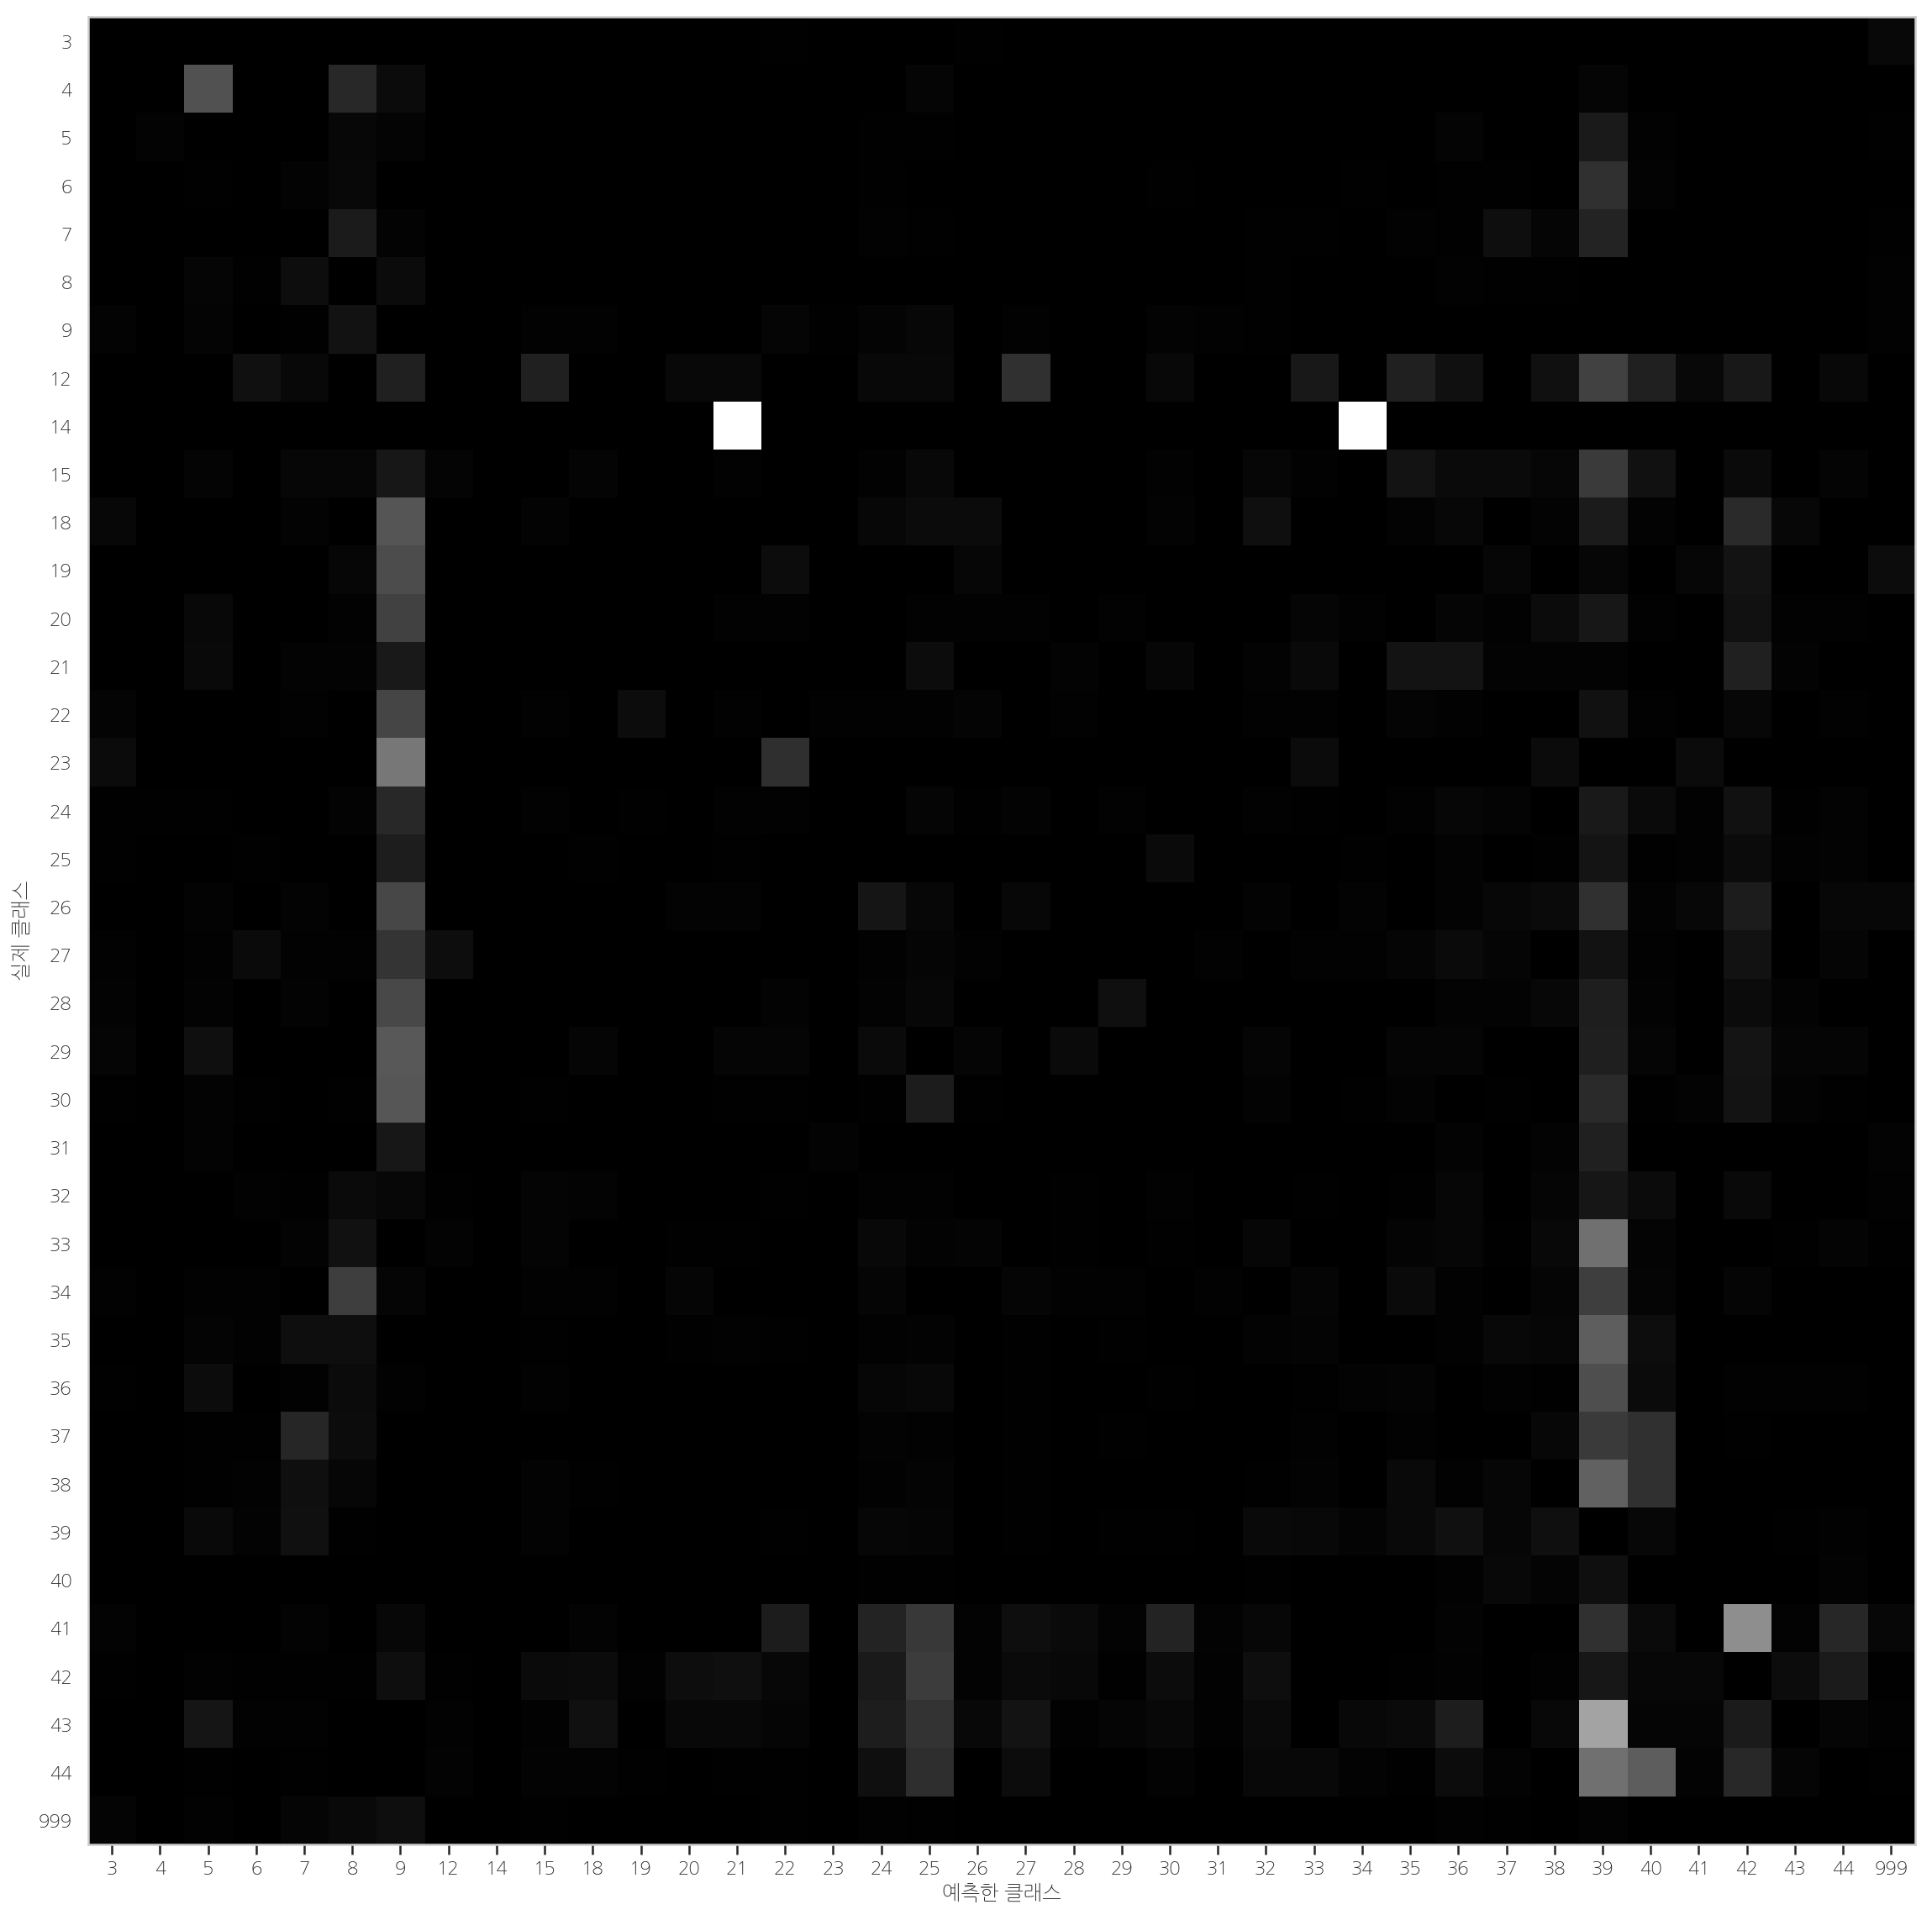

In [235]:
class_ls = list(np.unique(label_enc.inverse_transform(y_test)))
conf_mx = confusion_matrix(label_enc.inverse_transform(
    y_test), label_enc.inverse_transform(y_pred))
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)


fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.matshow(norm_conf_mx, cmap=plt.cm.gray)
ax.set_xticklabels(['']+class_ls)
ax.set_yticklabels(['']+class_ls)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_ticks_position('bottom')

plt.xlabel("예측한 클래스")
plt.ylabel('실제 클래스')
plt.grid(False)
plt.show()

In [237]:
pd.value_counts(pd.Series(label_enc.inverse_transform(y_test)))

8      3017
39     2507
9      2307
999    2100
40     1534
7      1494
5      1167
25      945
3       931
36      758
38      730
37      714
24      652
35      510
32      485
42      458
33      318
6       309
44      295
30      265
15      237
22      207
27      193
43      188
34      188
20      173
21      158
31      153
26      144
41      144
28      135
18      131
29       98
4        87
19       80
12       62
23       43
14        2
dtype: int64

# <center>5. kaggle 제출</center>

In [117]:
result = lightgbm_model.predict(total_test)
samplesub = pd.read_csv('sample_submission.csv')
subform_df_columns = samplesub.columns[1:]
result_df = pd.DataFrame(result)
result_df.columns = subform_df_columns
subform_df = pd.concat([test.reset_index()[
                       'VisitNumber'], result_df], axis=1)
subform_df.set_index('VisitNumber', inplace=True)
subform_df.tail()

,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,TripType_15,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
VisitNumber,,,,,,,,,,,,,,,,,,,,,
191338,1.866770e-06,8.726836e-07,0.000065,2.098174e-05,0.001708,0.000138,0.000069,0.000053,4.964321e-10,0.000210,...,0.000103,0.000226,0.003652,0.417505,0.001776,0.000049,0.000198,0.003296,0.001007,0.000319
191339,4.561791e-06,3.782873e-06,0.000112,2.587609e-04,0.000135,0.001288,0.001496,0.000033,8.685972e-10,0.000802,...,0.000190,0.000120,0.000345,0.009009,0.000147,0.007503,0.226196,0.013408,0.001625,0.001613
191340,5.379410e-06,1.375365e-05,0.000260,2.511687e-04,0.000241,0.791454,0.184345,0.000018,7.562748e-10,0.000786,...,0.000220,0.000079,0.000095,0.000502,0.000074,0.000031,0.001280,0.000033,0.000036,0.014996
191341,5.692593e-07,6.667917e-08,0.000005,5.753875e-07,0.000004,0.000022,0.000070,0.000025,5.144438e-11,0.000020,...,0.000058,0.000006,0.000004,0.003867,0.000118,0.000178,0.000763,0.001720,0.006956,0.000065
191348,1.767811e-07,1.097413e-07,0.000025,9.457827e-07,0.000006,0.000156,0.000051,0.000001,5.063516e-11,0.000008,...,0.000166,0.000008,0.000007,0.000182,0.000010,0.013582,0.005583,0.001443,0.000769,0.000525


In [118]:
subform_df.to_csv('lightgbm_submission.csv')

# 캐글 submission : 170/1047(late submission)

![score](score.png)

# <center>감사합니다